# Health Care Provider Segmentation Analysis

In this notebook, we conduct a segmentation analysis of the health care providers in North Carolina.


# Contents

1. [Library and data loading](#1-loading)

2. [Data cleaning](#2-cleaning)

    [2.1 Missing values](#21-nulls)

    [2.2 Duplicated rows](#22-duplicated)

3. [Feature engineering](#3-fe)

    [3.1 Specialization, grouping and classification](#31-specialization)

    [3.2 Working hours](#32-hours)

    [3.3 Ownership](#33-ownership)

    [3.4 Languages spoken](#34-languages)

    [3.5 Providers per county](#35-providers)

4. [Clustering-specific data preparation](#4-prep)

    [4.1 Filtering the data](#41-filtering)
    
    [4.2 Aggregating the data](#42-aggregation)

5. [Exploring features relevant for clustering](#5-exploring)

6. [Feature Selection](#6-selection)

7. [Econding and Scaling](#7-scaling)

8. [Modeling](#8-modeling)

    [8.1 K-Means Clustering](#81-kmeans)
    - 8.1.1 Characterizing the identified clusters
    - 8.1.2 Evaluating the robustness of the clustering model
    
9. [Appendix](#appendix)

    [9.1 Agglomerative Clustering](#91-agglomerative)

    - 9.1.1 Characterizing the identified clusters
    - 9.1.2 Inspecting the dendogram
    - 9.1.3 Evaluating the robustness of the clustering model
    
    [9.2 DBSCAN](#92-dbscan)

    - 9.2.1 Characterizing the identified clusters

#### 1. Library and data loading <a id='1-loading'></a>

In [1]:
# import necessary libraries
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import ast
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from functools import lru_cache
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage

bold = "\033[1m"
reset = "\033[0m"

In [2]:
# load the data
data = pd.read_excel('datos_ie.xlsx')
data.head(10)

,npi,countyID,census_tract,zip5,service_year,service_quarter,standard_services_claims,tele_services_claims,total_claims,standard_services_patients,tele_services_patients,total_patients,standard_services_claims_year,tele_services_claims_year,total_claims_year,standard_services_patients_year,tele_services_patients_year,total_patients_year,standard_services_psychotherapy_claims,tele_services_psychotherapy_claims,total_psychotherapy_claims,standard_services_psychotherapy_patients,tele_services_psychotherapy_patients,total_psychotherapy_patients,standard_services_psychotherapy_claims_year,tele_services_psychotherapy_claims_year,total_psychotherapy_claims_year,standard_services_psychotherapy_patients_year,tele_services_psychotherapy_patients_year,total_psychotherapy_patients_year,NPI_Deactivation_Reason_Code,NPI_Deactivation_Date,NPI_Reactivation_Date,Healthcare_Provider_Taxonomy_Code_1,Grouping_1,Classification_1,Specialization_1,Display_Name_1,%psychotherapy_claims,%teleService_claims,%tele_psychotherapy_claims,%psychotherapy_patients,%stdService_patients,%teleService_patients,%tele_psychotherapy_patients,%psychotherapy_claims_year,%teleService_claims_year,%tele_psychotherapy_claims_year,%psychotherapy_patients_year,%stdService_patients_year,%teleService_patients_year,%tele_psychotherapy_patients_year,psychotherapy_provider_through_taxonomy,provided_psychotherapy,psychotherapy_provider,countyname,urbanity,lat,long,transport_access,broadband_access,total_medicaid_claims,total_medicaid_patients,provider_size,Entity_Type_Code,AH_Sign language services for the deaf and hard of hearing,EN_English,SP_Spanish,NX_American Indian or Alaska Native languages,FX_Other languages (excluding Spanish),F4_Arabic,F17_Any Chinese Language,F19_Creole,F25_Farsi,F28_French,F30_German,F31_Greek,F35_Hebrew,F36_Hindi,F37_Hmong,F42_Italian,F43_Japanese,F47_Korean,F66_Polish,F67_Portuguese,F70_Russian,F81_Tagalog,F92_Vietnamese,N24_Ojibwa,N40_Yupik,Spoken_Language_Accessibility,black_owned,latino_owned,lgbtq+_owned,veteran_owned,women_owned,owner_identification,planning_accepts_new_patients,business_status,working_hours_cleaned,Weekend Availability,Availability Before 8AM,Availability After 5PM,total_commercial_claims,total_commercial_patients,total_medicare_claims,total_medicare_patients,total_other_payers_claims,total_other_payers_patients,total_commercial_claims_year,total_commercial_patients_year,total_medicaid_claims_year,total_medicaid_patients_year,total_medicare_claims_year,total_medicare_patients_year,total_other_payers_claims_year,total_other_payers_patients_year
0,1,51,16.04,28348,2020,2,0,0,0,0,0,0,0,8,8,0,5,5,0,0,0,0,0,0,0,8,8,0,5,5,NaN,NaT,NaT,101YA0400X,Behavioral Health & Social Service Providers,Counselor,Addiction (Substance Use Disorder),Addiction (Substance Use Disorder) Counselor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,1.0,0.000000,1.000000,1.000000,1,1,1,Cumberland,Urban,34.985025,-78.916585,0.900,0.89,0,0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,Info Not Available,Info Not Available,Info Not Available,Info Not Available,Info Not Available,0,0,0,0,8,2,0,0,0,0,0,0,16,4
1,1,51,16.04,28348,2020,1,0,0,0,0,0,0,0,8,8,0,5,5,0,0,0,0,0,0,0,8,8,0,5,5,NaN,NaT,NaT,101YA0400X,Behavioral Health & Social Service Providers,Counselor,Addiction (Substance Use Disorder),Addiction (Substance Use Disorder) Counselor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,1.0,0.000000,1.000000,1.000000,1,1,1,Cumberland,Urban,34.985025,-78.916585,0.900,0.89,0,0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,Info Not Available,Info Not Available,Info Not Available,Info Not Available,Info Not Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,51,16.04,28348,2020,3,0,2,2,0,2,2,0,8,8,0,5,5,0,2,2,0,2,2,0,8,8,0,5,5,NaN,NaT,NaT,101YA0400X,Behavioral Health & Social Service Providers,Counselor,Addiction (Substance Use Disorder),Addiction (Substance Use Disorder) Counselor,1.0,1.

### 2. Data cleaning <a id='2-cleaning'></a>

The same data cleaning steps are carried out as when preparing the data for demand prediction modeling, except lagged variables are not created since these are not relevant for the clustering analysis. Further documentation of the data cleaning steps is provided in the demand modelling notebook. 

#### 2.1 Nulls <a id='21-nulls'></a>

In [3]:
# Percentage of missing values in each column
print("\nPercentage of missing values in each column:")
null_percentage = data.isnull().mean() * 100
null_percentage = null_percentage[null_percentage > 0]
for col, percentage in null_percentage.items():
    print(f'Column "{bold+col+reset}" has {percentage:.2f}% missing values.')


Percentage of missing values in each column:
Column "NPI_Deactivation_Reason_Code" has 100.00% missing values.
Column "NPI_Deactivation_Date" has 99.86% missing values.
Column "NPI_Reactivation_Date" has 99.86% missing values.
Column "Specialization_1" has 38.26% missing values.


In [4]:
# drop features due to nulls (we will deal with Specialization_1 later)
data = data.drop(columns=["NPI_Deactivation_Reason_Code", "NPI_Deactivation_Date", "NPI_Reactivation_Date"])

#### 2.2 Duplicated rows <a id='22-duplicated'></a>

In [5]:
# Checking for duplicates
print(f"Number of duplicate rows: {data.duplicated().sum()}")

Number of duplicate rows: 0


### 3. Feature engineering <a id='3-fe'></a>

#### 3.1 Specialization, groupings and classification <a id='31-specialization'></a>

In [6]:
# reading the content of the file containing the specialization groupings based on WHO's framework
file_path = "specialization_dict.txt"

with open(file_path, "r") as file:
    dict_content = file.read()

specialization_dict = ast.literal_eval(dict_content)

In [7]:
# Trying to impute the null values in the 'Specialization_1' column, we analyze the common text in the corresponding values of the first and third columns; if any part of the common text matches any of the existing specializations, we replace the null value with it; otherwise, we add the common text 

df_null_specialization_1 = data[data['Specialization_1'].isnull()][['Classification_1', 'Specialization_1', 'Display_Name_1']]

@lru_cache(maxsize=None)
def longest_common_substring(s1, s2):
    m = [[0] * (1 + len(s2)) for _ in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

unique_values = set(data['Specialization_1'].dropna().unique())

def common_substring(row):
    classification = str(row['Classification_1'])
    display_name = str(row['Display_Name_1'])
    common_string = longest_common_substring(classification, display_name)

    excluded_values = ['health', 'medical', 'registered', "children"]
    
    unique_values_matched = [value for value in unique_values
                             if value.lower() not in excluded_values
                             and value in common_string]
    if unique_values_matched:
        return ' '.join(unique_values_matched)  # if there are any matches within unique_values, we return them joined by a space
    else:
        return common_string  # else, we return the common_string itself

df_null_specialization_1['common_text'] = df_null_specialization_1.apply(common_substring, axis=1)

data_engineered = data.copy()

data_engineered.loc[df_null_specialization_1.index, 'Specialization_1'] = df_null_specialization_1['common_text']

unique_values_after_imputation = data_engineered['Specialization_1'].unique()

# Overview of the new specializations added
# Convert your arrays of unique values into sets
unique_values_after_imputation_set = set(unique_values_after_imputation)

# Get the new unique values after imputation by finding the set difference
new_unique_values = unique_values_after_imputation_set - unique_values

In [8]:
# In addition to combining different mental-health-related specializations, we look at the sorted number of total claims
# per specialization and the total mental-health-related claims vs. non-mental-health claims
# The phrases or string patterns we're looking for:
search_phrases = ["mental health", "psych", "professional", "counselor", "counseling", "addiction",
                  "community/behavioral health", "clinical neurophysiology", "neurodevelopmental disabilities",
                  "cognitive & behavioral", "behavior", "behavior technician", "rehabilitation, substance use disorder"]

# Initialize the lists for matching and non-matching values
matching_values = []
non_matching_values = []

# Iterate over all unique values
for value in unique_values_after_imputation:
    lower_value = str(value).lower()
    
    # Check if any of the phrases is in 'value'
    if any(phrase in lower_value for phrase in search_phrases):
        matching_values.append(value)
    else:
        non_matching_values.append(value)

# Add to matching_values where Classification_1 is Psychiatry & Neurology and not in exclude_specializations
more_matching_values = data_engineered[data_engineered['Classification_1'] == 'Psychiatry & Neurology']['Specialization_1'].unique()
matching_values.extend(more_matching_values)

non_matching_values = list(set(non_matching_values) - set(more_matching_values))

category_total_claims = {}
    
matching_sum = data_engineered[data_engineered['Specialization_1'].isin(matching_values)]['total_claims'].sum()
non_matching_sum = data_engineered[data_engineered['Specialization_1'].isin(non_matching_values)]['total_claims'].sum()

# Iterate over all matching values (mental health categories)
for category in matching_values:
    total_claims = data_engineered[data_engineered['Specialization_1'] == category]['total_claims'].sum()

    category_total_claims[category] = total_claims

sorted_category_total_claims = dict(sorted(category_total_claims.items(), key=lambda item: item[1], reverse=True))

data_engineered['mental_health'] = data_engineered['Specialization_1'].isin(matching_values).astype(int)

In [9]:
# creating specialization_group feature based on the dictionary loaded earlier
data_engineered['specialization_group'] = data_engineered['Specialization_1'].apply(lambda x: specialization_dict.get(x, 'mental_health'))

#### 3.2 Working hours <a id='32-hours'></a>

In [10]:
# creating a dummy variable stating whether working hours information has been provided or not 
data_engineered['working_hours_owner_missing_info'] = (data_engineered['business_status'] == 'Info Not Available').astype(int)

In [11]:
# cleaning business_status feature
data_engineered['business_status'] = data_engineered['business_status'].replace({
    'CLOSED_PERMANENTLY': 'CLOSED',
    'CLOSED_TEMPORARILY': 'CLOSED'})

In [12]:
# cleaning Weekend Availability feature
data_engineered['Weekend Availability'] = data_engineered['Weekend Availability'].replace({
    'Only Saturday': 'Partially',
    'Only Sunday': 'Partially'})

#### 3.3 Ownership <a id='33-ownership'></a>

In [13]:
# creating minority_owned feature
data_engineered['minority_owned'] = data_engineered['owner_identification'].apply(
    lambda x: 0 if x == 'Info Not Available' else 1
)

#### 3.4 Languages spoken <a id='34-languages'></a>

In [14]:
# reencoding and renaming Spoken_Language_Accessibility feature
data_engineered['extra_languages_spoken'] = data_engineered.apply(
    lambda row: row['Spoken_Language_Accessibility'] - 1 if row['EN_English'] == 1 else row['Spoken_Language_Accessibility'], 
    axis=1
)

data_engineered['extra_languages_spoken'] = data_engineered['extra_languages_spoken'].replace(23, 0)

data_engineered.drop(columns=['Spoken_Language_Accessibility'], inplace=True)

#### 3.5 Providers per county <a id='35-providers'></a>

In [15]:
# Creation of providers_per_country feature
# Create grouped dataframes
provider_group = data_engineered.groupby('npi')
county_group = data_engineered.groupby('countyID')

# Get the number of providers per county for each year
providers_per_county_year = data_engineered.groupby(['countyID', 'service_year'])['npi'].nunique()

# This is a multi-index series (i.e., series with multiple indices: countyID and Year)
# So we will reset its index to make it a DataFrame, making it easier to merge with the original data
providers_per_county_year = providers_per_county_year.reset_index()
providers_per_county_year.rename(columns={'npi': 'providers_per_county'}, inplace=True)

# Merge this DataFrame with the original data to get the providers per county for the respective year in each record
data_engineered = pd.merge(data_engineered, providers_per_county_year, on=['countyID', 'service_year'], how='left')

In [16]:
# to enable sorting of the dataframe, we momentarily create a year_quarter feature
data_engineered['year_quarter'] = data_engineered['service_year'].astype(str) + ' Q' + data_engineered['service_quarter'].astype(str) 
data_engineered = data_engineered.sort_values(by=['npi', 'year_quarter'])
data_engineered.drop(columns=['year_quarter'], inplace=True) # not needed any longer

### 4. Clustering-specific data preparation <a id='4-prep'></a>

#### 4.1 Filtering the dataset <a id='41-filtering'></a>

We want the supply segmentation to be "up to date". Hence, we will focus on the observations in the dataset relating to the recent year, i.e., 2020.

In [17]:
df2020 = data_engineered[(data_engineered['service_year'] == 2020)].copy() # filter df for 2020 observations only

In [18]:
# NPIs from complete dataset and 2020-dataset 
npis_all = set(data_engineered['npi'])
npis_2020 = set(df2020['npi'])

# NPIs that are in data_engineered but not in df2020
npi_not_in_2020 = npis_all - npis_2020

print('Total unique NPIs in dataset with observations in 2020:', len(npis_2020))
print('Total unique NPIs in dataset:', len(npis_all))
print('NPIs not recorded/active in 2020:', len(npi_not_in_2020)) 

Total unique NPIs in dataset with observations in 2020: 8920
Total unique NPIs in dataset: 11383
NPIs not recorded/active in 2020: 2463


The NPIs not recorded/active in 2020 will make up a "not active" cluster. The remaining NPIs will be clustered using an unsupervised learning algorithm.

#### 4.2 Aggregating the dataset <a id='42-aggregation'></a>

In [19]:
# exploring columns considering which aggregation functions are appropriate
col_list = list(df2020.columns)
col_list

['npi',
 'countyID',
 'census_tract',
 'zip5',
 'service_year',
 'service_quarter',
 'standard_services_claims',
 'tele_services_claims',
 'total_claims',
 'standard_services_patients',
 'tele_services_patients',
 'total_patients',
 'standard_services_claims_year',
 'tele_services_claims_year',
 'total_claims_year',
 'standard_services_patients_year',
 'tele_services_patients_year',
 'total_patients_year',
 'standard_services_psychotherapy_claims',
 'tele_services_psychotherapy_claims',
 'total_psychotherapy_claims',
 'standard_services_psychotherapy_patients',
 'tele_services_psychotherapy_patients',
 'total_psychotherapy_patients',
 'standard_services_psychotherapy_claims_year',
 'tele_services_psychotherapy_claims_year',
 'total_psychotherapy_claims_year',
 'standard_services_psychotherapy_patients_year',
 'tele_services_psychotherapy_patients_year',
 'total_psychotherapy_patients_year',
 'Healthcare_Provider_Taxonomy_Code_1',
 'Grouping_1',
 'Classification_1',
 'Specialization_1',

We need to group the dataset by NPI. Hence, we define which aggregation function to use for each feature. 

- For numerical variables, we generally take the mean value across the 4 quarters observed in 2020. 
- For categorical variables, we generally take the last recorded value of the feature.

In [20]:
# Define aggregation functions for each column

agg_funcs = {
    'countyID': 'last', 
    'census_tract': 'last',
    'zip5': 'last',
    'service_year': 'last',
    'service_quarter': 'last',
    'standard_services_claims': 'mean',
    'tele_services_claims': 'mean',
    'total_claims': 'mean',
    'standard_services_patients': 'mean',
    'tele_services_patients': 'mean',
    'total_patients': 'mean',
    'standard_services_claims_year': 'last',
    'tele_services_claims_year': 'last',
    'total_claims_year': 'last',
    'standard_services_patients_year': 'last',
    'tele_services_patients_year': 'last',
    'total_patients_year': 'last',
    'standard_services_psychotherapy_claims': 'mean',
    'tele_services_psychotherapy_claims': 'mean',
    'total_psychotherapy_claims': 'mean',
    'standard_services_psychotherapy_patients': 'mean',
    'tele_services_psychotherapy_patients': 'mean',
    'total_psychotherapy_patients': 'mean',
    'standard_services_psychotherapy_claims_year': 'last',
    'tele_services_psychotherapy_claims_year': 'last',
    'total_psychotherapy_claims_year': 'last',
    'standard_services_psychotherapy_patients_year': 'last',
    'tele_services_psychotherapy_patients_year': 'last',
    'total_psychotherapy_patients_year': 'last',
    'Healthcare_Provider_Taxonomy_Code_1': 'last',
    'Grouping_1': 'last',
    'Classification_1': 'last',
    'Specialization_1': 'last',
    'Display_Name_1': 'last',
    '%psychotherapy_claims': 'mean',
    '%teleService_claims': 'mean',
    '%tele_psychotherapy_claims': 'mean',
    '%psychotherapy_patients': 'mean',
    '%stdService_patients': 'mean',
    '%teleService_patients': 'mean',
    '%tele_psychotherapy_patients': 'mean',
    '%psychotherapy_claims_year': 'mean',
    '%teleService_claims_year': 'mean',
    '%tele_psychotherapy_claims_year': 'mean',
    '%psychotherapy_patients_year': 'mean',
    '%stdService_patients_year': 'mean',
    '%teleService_patients_year': 'mean',
    '%tele_psychotherapy_patients_year': 'mean',
    'psychotherapy_provider_through_taxonomy': 'last',
    'provided_psychotherapy': 'last',
    'psychotherapy_provider': 'last',
    'countyname': 'last',
    'urbanity': 'last',
    'lat': 'last',
    'long': 'last',
    'transport_access': 'last',
    'broadband_access': 'last',
    'total_medicaid_claims': 'mean',
    'total_medicaid_patients': 'mean',
    'provider_size': 'last',
    'Entity_Type_Code': 'last',
    'AH_Sign language services for the deaf and hard of hearing': 'last',
    'EN_English': 'last',
    'SP_Spanish': 'last',
    'NX_American Indian or Alaska Native languages': 'last',
    'FX_Other languages (excluding Spanish)': 'last',
    'F4_Arabic': 'last',
    'F17_Any Chinese Language': 'last',
    'F19_Creole': 'last',
    'F25_Farsi': 'last',
    'F28_French': 'last',
    'F30_German': 'last',
    'F31_Greek': 'last',
    'F35_Hebrew': 'last',
    'F36_Hindi': 'last',
    'F37_Hmong': 'last',
    'F42_Italian': 'last',
    'F43_Japanese': 'last',
    'F47_Korean': 'last',
    'F66_Polish': 'last',
    'F67_Portuguese': 'last',
    'F70_Russian': 'last',
    'F81_Tagalog': 'last',
    'F92_Vietnamese': 'last',
    'N24_Ojibwa': 'last',
    'N40_Yupik': 'last',
    'black_owned': 'last',
    'latino_owned': 'last',
    'lgbtq+_owned': 'last',
    'veteran_owned': 'last',
    'women_owned': 'last',
    'owner_identification': 'last',
    'planning_accepts_new_patients': 'last',
    'business_status': 'last',
    'working_hours_cleaned': 'last',
    'Weekend Availability': 'last',
    'Availability Before 8AM': 'last',
    'Availability After 5PM': 'last',
    'total_commercial_claims': 'mean',
    'total_commercial_patients': 'mean',
    'total_medicare_claims': 'mean',
    'total_medicare_patients': 'mean',
    'total_other_payers_claims': 'mean',
    'total_other_payers_patients': 'mean',
    'total_commercial_claims_year': 'mean',
    'total_commercial_patients_year': 'mean',
    'total_medicaid_claims_year': 'mean',
    'total_medicaid_patients_year': 'mean',
    'total_medicare_claims_year': 'mean',
    'total_medicare_patients_year': 'mean',
    'total_other_payers_claims_year': 'mean',
    'total_other_payers_patients_year': 'mean',
     'mental_health': 'last', 
     'specialization_group': 'last',
     'working_hours_owner_missing_info': 'last', 
     'minority_owned': 'last',
     'extra_languages_spoken': 'last',
     'providers_per_county': 'mean'
}

# Aggregate the data
df_aggregated = df2020.groupby('npi').agg(agg_funcs) # keeping NPI as index to enable mapping to demand prediction
df_aggregated.head()

,countyID,census_tract,zip5,service_year,service_quarter,standard_services_claims,tele_services_claims,total_claims,standard_services_patients,tele_services_patients,total_patients,standard_services_claims_year,tele_services_claims_year,total_claims_year,standard_services_patients_year,tele_services_patients_year,total_patients_year,standard_services_psychotherapy_claims,tele_services_psychotherapy_claims,total_psychotherapy_claims,standard_services_psychotherapy_patients,tele_services_psychotherapy_patients,total_psychotherapy_patients,standard_services_psychotherapy_claims_year,tele_services_psychotherapy_claims_year,total_psychotherapy_claims_year,standard_services_psychotherapy_patients_year,tele_services_psychotherapy_patients_year,total_psychotherapy_patients_year,Healthcare_Provider_Taxonomy_Code_1,Grouping_1,Classification_1,Specialization_1,Display_Name_1,%psychotherapy_claims,%teleService_claims,%tele_psychotherapy_claims,%psychotherapy_patients,%stdService_patients,%teleService_patients,%tele_psychotherapy_patients,%psychotherapy_claims_year,%teleService_claims_year,%tele_psychotherapy_claims_year,%psychotherapy_patients_year,%stdService_patients_year,%teleService_patients_year,%tele_psychotherapy_patients_year,psychotherapy_provider_through_taxonomy,provided_psychotherapy,psychotherapy_provider,countyname,urbanity,lat,long,transport_access,broadband_access,total_medicaid_claims,total_medicaid_patients,provider_size,Entity_Type_Code,AH_Sign language services for the deaf and hard of hearing,EN_English,SP_Spanish,NX_American Indian or Alaska Native languages,FX_Other languages (excluding Spanish),F4_Arabic,F17_Any Chinese Language,F19_Creole,F25_Farsi,F28_French,F30_German,F31_Greek,F35_Hebrew,F36_Hindi,F37_Hmong,F42_Italian,F43_Japanese,F47_Korean,F66_Polish,F67_Portuguese,F70_Russian,F81_Tagalog,F92_Vietnamese,N24_Ojibwa,N40_Yupik,black_owned,latino_owned,lgbtq+_owned,veteran_owned,women_owned,owner_identification,planning_accepts_new_patients,business_status,working_hours_cleaned,Weekend Availability,Availability Before 8AM,Availability After 5PM,total_commercial_claims,total_commercial_patients,total_medicare_claims,total_medicare_patients,total_other_payers_claims,total_other_payers_patients,total_commercial_claims_year,total_commercial_patients_year,total_medicaid_claims_year,total_medicaid_patients_year,total_medicare_claims_year,total_medicare_patients_year,total_other_payers_claims_year,total_other_payers_patients_year,mental_health,specialization_group,working_hours_owner_missing_info,minority_owned,extra_languages_spoken,providers_per_county
npi,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,51,16.04,28348,2020,4,0.00,2.00,2.00,0.00,1.50,1.50,0,8,8,0,5,5,0.00,2.00,2.00,0.00,1.50,1.50,0,8,8,0,5,5,101YA0400X,Behavioral Health & Social Service Providers,Counselor,Addiction (Substance Use Disorder),Addiction (Substance Use Disorder) Counselor,0.500,0.5000,0.500,0.50,0.000,0.500,0.500,1.0,1.00,1.0,1.0,0.0,1.0,1.0,1,1,1,Cumberland,Urban,34.985025,-78.916585,0.900,0.89,0.0,0.0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,Info Not Available,Info Not Available,Info Not Available,Info Not Available,Info Not Available,0.0,0.0,0.0,0.0,2.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,3.00,1,mental_health,1,0,0,461.0
2,71,328.00,28052,2020,4,0.00,3.00,3.00,0.00,0.50,0.50,0,12,12,0,1,1,0.00,3.00,3.00,0.00,0.50,0.50,0,12,12,0,1,1,1041C0700X,Behavioral Health & Social Service Providers,Social Worker,Clinical,Clinical Social Worker,0.500,0.5000,0.500,0.50,0.000,0.500,0.500,1.0,1.00,1.0,1.0,0.0,1.0,1.0,1,1,1,Gaston,Urban,35.258674,-81.180363,0.697,0.26,0.0,0.0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,OPERATIONAL,Info Not Available,No,No,No,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,Multi-Specialty Groups and Organizations,0,0,0,139.0
3,81,153.02,27377,2020,

In [21]:
df_aggregated.shape

(8920, 118)

### 5. Exploring features relevant for clustering <a id='5-exploring'></a>

Before fitting unsupervised learning algorithms to the dataset, some of the descriptive features in the dataset are explored to inform feature selection for the clustering task.

In [22]:
# exploring the language-related columns

language_columns = ['AH_Sign language services for the deaf and hard of hearing',
       'EN_English', 'SP_Spanish',
       'NX_American Indian or Alaska Native languages',
       'FX_Other languages (excluding Spanish)', 'F4_Arabic',
       'F17_Any Chinese Language', 'F19_Creole', 'F25_Farsi', 'F28_French',
       'F30_German', 'F31_Greek', 'F35_Hebrew', 'F36_Hindi', 'F37_Hmong',
       'F42_Italian', 'F43_Japanese', 'F47_Korean', 'F66_Polish',
       'F67_Portuguese', 'F70_Russian', 'F81_Tagalog', 'F92_Vietnamese',
       'N24_Ojibwa', 'N40_Yupik', 'extra_languages_spoken']

# Checking for value counts of language columns
for col in language_columns:
    print(df_aggregated[col].value_counts())
    print('______________________________________________________')

AH_Sign language services for the deaf and hard of hearing
0    8849
1      71
Name: count, dtype: int64
______________________________________________________
EN_English
0    8889
1      31
Name: count, dtype: int64
______________________________________________________
SP_Spanish
0    8844
1      76
Name: count, dtype: int64
______________________________________________________
NX_American Indian or Alaska Native languages
0    8856
1      64
Name: count, dtype: int64
______________________________________________________
FX_Other languages (excluding Spanish)
0    8856
1      64
Name: count, dtype: int64
______________________________________________________
F4_Arabic
0    8856
1      64
Name: count, dtype: int64
______________________________________________________
F17_Any Chinese Language
0    8856
1      64
Name: count, dtype: int64
______________________________________________________
F19_Creole
0    8856
1      64
Name: count, dtype: int64
___________________________________

The language-related columns have very few "True" observations across the different languages. Hence, the individual language features are likely not meaningful to use for clustering. The aggregated language feature 'extra_languages_spoken' may be useful. 

In [23]:
owner_columns = ['black_owned',
    'latino_owned',
    'lgbtq+_owned',
    'veteran_owned',
    'women_owned',
    'owner_identification',
    'minority_owned']

# Checking for value counts of language columns
for col in owner_columns:
    print(df_aggregated[col].value_counts())
    print('______________________________________________________')

black_owned
0    8905
1      15
Name: count, dtype: int64
______________________________________________________
latino_owned
0    8917
1       3
Name: count, dtype: int64
______________________________________________________
lgbtq+_owned
0    8918
1       2
Name: count, dtype: int64
______________________________________________________
veteran_owned
0    8914
1       6
Name: count, dtype: int64
______________________________________________________
women_owned
0    8840
1      80
Name: count, dtype: int64
______________________________________________________
owner_identification
Info Not Available           8837
Women Owned                    62
Black Women Owned              14
Veteran Women Owned             3
Veteran Owned                   2
Latino Owned                    1
Black Veteran Women Owned       1
Name: count, dtype: int64
______________________________________________________
minority_owned
0    8837
1      83
Name: count, dtype: int64
______________________________

Similarly, the owner-related columns have very few "True" observations across the different features, and are therefore likely not meaningful to use for clustering. The aggregated minority_owned feature may be useful.

In [24]:
# exploring specific "descriptive" variables
desc_columns = ['mental_health',
    'business_status',
    'working_hours_owner_missing_info',
    'Availability Before 8AM',
    'Availability After 5PM',
    'Weekend Availability',
    'planning_accepts_new_patients',
    'provider_size',
    'psychotherapy_provider_through_taxonomy',
    'specialization_group',
    'Grouping_1',
     'provided_psychotherapy',
    'psychotherapy_provider'
    ]

# Checking for value counts of language columns
for col in desc_columns:
    print(df_aggregated[col].value_counts())
    print('______________________________________________________')

mental_health
0    5326
1    3594
Name: count, dtype: int64
______________________________________________________
business_status
Info Not Available    5800
OPERATIONAL           2898
CLOSED                 222
Name: count, dtype: int64
______________________________________________________
working_hours_owner_missing_info
1    5800
0    3120
Name: count, dtype: int64
______________________________________________________
Availability Before 8AM
Info Not Available    5800
No                    2933
Yes                    187
Name: count, dtype: int64
______________________________________________________
Availability After 5PM
Info Not Available    5800
No                    2608
Yes                    512
Name: count, dtype: int64
______________________________________________________
Weekend Availability
Info Not Available    5800
No                    2849
Yes                    139
Partially              132
Name: count, dtype: int64
_______________________________________________

In [25]:
# exploring specific "descriptive" variables
desc_columns2 = [
    'countyname',
    'Classification_1',
    'Specialization_1',
    'specialization_group',
    'Grouping_1',
    'Display_Name_1'
    ]

# Checking for value counts of language columns
for col in desc_columns2:
    print(f'Unique values for {col}: {df_aggregated[col].nunique()}')
    print('______________________________________________________')

Unique values for countyname: 99
______________________________________________________
Unique values for Classification_1: 93
______________________________________________________
Unique values for Specialization_1: 186
______________________________________________________
Unique values for specialization_group: 15
______________________________________________________
Unique values for Grouping_1: 26
______________________________________________________
Unique values for Display_Name_1: 225
______________________________________________________


Some of the above categorical variables have too many unique values for clustering. However, 'specialization_group' and 'Grouping_1' may be useful.

In [26]:
# checking for nulls
for col in df_aggregated.columns:
    print(col, df_aggregated[col].isnull().sum())
    print('______________________________________________________')

countyID 0
______________________________________________________
census_tract 0
______________________________________________________
zip5 0
______________________________________________________
service_year 0
______________________________________________________
service_quarter 0
______________________________________________________
standard_services_claims 0
______________________________________________________
tele_services_claims 0
______________________________________________________
total_claims 0
______________________________________________________
standard_services_patients 0
______________________________________________________
tele_services_patients 0
______________________________________________________
total_patients 0
______________________________________________________
standard_services_claims_year 0
______________________________________________________
tele_services_claims_year 0
______________________________________________________
total_claims_year 0
___

In [27]:
# identifying boolean features
# if the only values are 0 and 1 for a column, put the type of the col to boolean 
for col in df_aggregated.columns:
    if list(df_aggregated[col].unique()) in [[0, 1], [1, 0]]:
        df_aggregated[col] = df_aggregated[col].astype(bool)

In [28]:
# checking data types
for col in df_aggregated.columns:
    # print col and dtype
    print(col, df_aggregated[col].dtype)
    print('______________________________________________________')

countyID int64
______________________________________________________
census_tract float64
______________________________________________________
zip5 int64
______________________________________________________
service_year int64
______________________________________________________
service_quarter int64
______________________________________________________
standard_services_claims float64
______________________________________________________
tele_services_claims float64
______________________________________________________
total_claims float64
______________________________________________________
standard_services_patients float64
______________________________________________________
tele_services_patients float64
______________________________________________________
total_patients float64
______________________________________________________
standard_services_claims_year int64
______________________________________________________
tele_services_claims_year int64
____________

### 6. Feature selection <a id='6-selection'></a>

In [29]:
# showing all columns
cols = list(df_aggregated.columns)
cols

['countyID',
 'census_tract',
 'zip5',
 'service_year',
 'service_quarter',
 'standard_services_claims',
 'tele_services_claims',
 'total_claims',
 'standard_services_patients',
 'tele_services_patients',
 'total_patients',
 'standard_services_claims_year',
 'tele_services_claims_year',
 'total_claims_year',
 'standard_services_patients_year',
 'tele_services_patients_year',
 'total_patients_year',
 'standard_services_psychotherapy_claims',
 'tele_services_psychotherapy_claims',
 'total_psychotherapy_claims',
 'standard_services_psychotherapy_patients',
 'tele_services_psychotherapy_patients',
 'total_psychotherapy_patients',
 'standard_services_psychotherapy_claims_year',
 'tele_services_psychotherapy_claims_year',
 'total_psychotherapy_claims_year',
 'standard_services_psychotherapy_patients_year',
 'tele_services_psychotherapy_patients_year',
 'total_psychotherapy_patients_year',
 'Healthcare_Provider_Taxonomy_Code_1',
 'Grouping_1',
 'Classification_1',
 'Specialization_1',
 'Displ

In [30]:
# columns selected for clustering

cluster_columns = [
    'total_claims',
    'Grouping_1',
    '%psychotherapy_patients',
    '%stdService_patients',
    '%teleService_patients',
    '%tele_psychotherapy_patients',
    'psychotherapy_provider_through_taxonomy',
    'urbanity', 
    'transport_access',
    'broadband_access',
    'provider_size',
    'planning_accepts_new_patients',
    'business_status',
    'Weekend Availability',
    'Availability Before 8AM',
    'Availability After 5PM',
    'mental_health',
    'specialization_group',
    'working_hours_owner_missing_info',
    'minority_owned',
    'extra_languages_spoken',
    'providers_per_county'
]

The above selection of features for the clustering analysis was an iterative process. Many different subsets of features were experimented with before finally deciding on the above as the optimal set of features for the analysis. This decision was based on a balanced view of the technical performance of the clustering algorithms when using specific feature sets as well as the relevance and meaningfulness of the clusters created when using specific feature sets.

In [31]:
df_final = df_aggregated[cluster_columns] # df to train clustering algorithm

In [32]:
df_final.head()

,total_claims,Grouping_1,%psychotherapy_patients,%stdService_patients,%teleService_patients,%tele_psychotherapy_patients,psychotherapy_provider_through_taxonomy,urbanity,transport_access,broadband_access,provider_size,planning_accepts_new_patients,business_status,Weekend Availability,Availability Before 8AM,Availability After 5PM,mental_health,specialization_group,working_hours_owner_missing_info,minority_owned,extra_languages_spoken,providers_per_county
npi,,,,,,,,,,,,,,,,,,,,,,
1,2.00,Behavioral Health & Social Service Providers,0.50,0.000,0.500,0.500,True,Urban,0.900,0.89,Small,False,Info Not Available,Info Not Available,Info Not Available,Info Not Available,True,mental_health,True,False,0,461.0
2,3.00,Behavioral Health & Social Service Providers,0.50,0.000,0.500,0.500,True,Urban,0.697,0.26,Small,False,OPERATIONAL,No,No,No,False,Multi-Specialty Groups and Organizations,False,False,0,139.0
3,1.00,Allopathic & Osteopathic Physicians,0.25,0.125,0.125,0.125,False,Urban,1.000,0.60,Small,True,OPERATIONAL,No,No,No,False,Specialized and Allied Health Services,False,False,0,400.0
4,2.25,Behavioral Health & Social Service Providers,0.25,0.250,0.000,0.000,True,Urban,0.985,0.53,Small,False,Info Not Available,Info Not Available,Info Not Available,Info Not Available,True,mental_health,True,False,0,1402.0
5,0.25,Behavioral Health & Social Service Providers,0.25,0.000,0.250,0.250,True,Urban,0.895,0.87,Small,False,Info Not Available,Info Not Available,Info Not Available,Info Not Available,True,mental_health,True,False,0,829.0


### 7. Enconding and Scaling  <a id='7-scaling'></a>

Clustering algorithms are generally distance-based, and it is therefore crucial to scale the numerical features prior to fitting the algorithms. 

In [33]:
# extracting features data
X = df_final.copy()
categorical_columns = X.select_dtypes(include=['object', 'bool']).columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

# encoding categorical columns
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X[categorical_columns]).toarray()

# scaling numerical columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numeric_columns])

# converting the encoded and scaled arrays back to dfs, retaining the original index
X_encoded_df = pd.DataFrame(X_encoded, index=X.index, columns=encoder.get_feature_names_out(categorical_columns))
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=numeric_columns)

# concatenating the encoded categorical DataFrame and the scaled numerical DataFrame
X_final_df = pd.concat([X_encoded_df, X_scaled_df], axis=1)
X_final_df.shape

(8920, 77)

In [34]:
# converting X_final to df 
cluster_df = X_final_df.copy() # creating copy to store clusters
X_final_df.head()

,Grouping_1_Agencies,Grouping_1_Allopathic & Osteopathic Physicians,Grouping_1_Ambulatory Health Care Facilities,Grouping_1_Behavioral Health & Social Service Providers,Grouping_1_Chiropractic Providers,Grouping_1_Dental Providers,Grouping_1_Dietary & Nutritional Service Providers,Grouping_1_Eye and Vision Services Providers,Grouping_1_Hospital Units,Grouping_1_Hospitals,Grouping_1_Laboratories,Grouping_1_Managed Care Organizations,Grouping_1_Nursing & Custodial Care Facilities,Grouping_1_Nursing Service Providers,Grouping_1_Nursing Service Related Providers,Grouping_1_Other Service Providers,Grouping_1_Pharmacy Service Providers,Grouping_1_Physician Assistants & Advanced Practice Nursing Providers,Grouping_1_Podiatric Medicine & Surgery Service Providers,Grouping_1_Residential Treatment Facilities,"Grouping_1_Respiratory, Developmental, Rehabilitative and Restorative Service Providers",Grouping_1_Respite Care Facility,"Grouping_1_Speech, Language and Hearing Service Providers","Grouping_1_Student, Health Care",Grouping_1_Suppliers,Grouping_1_Transportation Services,psychotherapy_provider_through_taxonomy_False,psychotherapy_provider_through_taxonomy_True,urbanity_Rural,urbanity_Urban,provider_size_Big,provider_size_Small,planning_accepts_new_patients_False,planning_accepts_new_patients_True,business_status_CLOSED,business_status_Info Not Available,business_status_OPERATIONAL,Weekend Availability_Info Not Available,Weekend Availability_No,Weekend Availability_Partially,Weekend Availability_Yes,Availability Before 8AM_Info Not Available,Availability Before 8AM_No,Availability Before 8AM_Yes,Availability After 5PM_Info Not Available,Availability After 5PM_No,Availability After 5PM_Yes,mental_health_False,mental_health_True,specialization_group_Community and Social Services,specialization_group_Emergency and Critical Care,specialization_group_Facility-Based Services,specialization_group_Internal Medicine and Specialties,specialization_group_Medical Imaging and Radiology,specialization_group_Multi-Specialty Groups and Organizations,specialization_group_Pediatrics,specialization_group_Primary Care and General,specialization_group_Primary Care and General Practice,specialization_group_Public Health and Preventive Medicine,specialization_group_Rehabilitation and Therapy,specialization_group_Specialized and Allied Health Services,specialization_group_Surgery and Related Specialties,specialization_group_Women Health,specialization_group_mental_health,working_hours_owner_missing_info_False,working_hours_owner_missing_info_True,minority_owned_False,minority_owned_True,total_claims,%psychotherapy_patients,%stdService_patients,%teleService_patients,%tele_psychotherapy_patients,transport_access,broadband_access,extra_languages_spoken,providers_per_county
npi,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-0.200044,-0.114316,-1.519480,0.453265,0.326305,-0.430110,0.738582,-0.040051,-0.138126
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.197023,-0.114316,-1.519480,0.453265,0.326305,-3.187552,-2.933029,-0.040051,-0.838561
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.203065,-0.811732,-1.071334,-1.003881,-1.046185,0.928236,-0.951525,-0.040051,-0.270817
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [35]:
# checking where nan values and seeing whole output 
X_final_df.isnull().sum().sort_values(ascending=False).head(5)

Grouping_1_Agencies                                              0
specialization_group_Community and Social Services               0
specialization_group_Primary Care and General                    0
specialization_group_Pediatrics                                  0
specialization_group_Multi-Specialty Groups and Organizations    0
dtype: int64

In [36]:
# checking for nonetype 
X_final_df.dtypes

Grouping_1_Agencies                                                                        float64
Grouping_1_Allopathic & Osteopathic Physicians                                             float64
Grouping_1_Ambulatory Health Care Facilities                                               float64
Grouping_1_Behavioral Health & Social Service Providers                                    float64
Grouping_1_Chiropractic Providers                                                          float64
Grouping_1_Dental Providers                                                                float64
Grouping_1_Dietary & Nutritional Service Providers                                         float64
Grouping_1_Eye and Vision Services Providers                                               float64
Grouping_1_Hospital Units                                                                  float64
Grouping_1_Hospitals                                                                       float64
Grouping_1

### 8. Modeling <a id='8-modeling'></a>

#### 8.1 K-Means Clustering <a id='81-kmeans'></a>

In [37]:
# creating a function to evaluate K-Means with different numbers of clusters using both inertia and silhouette score
def evaluate_kmeans(X, n_clusters_list):
    best_n_clusters = None
    best_silhouette = -1
    silhouette_scores = []
    inertia_values = []
    
    for n_clusters in n_clusters_list:
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=8)
        labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, labels)
        inertia = kmeans.inertia_
        
        silhouette_scores.append(silhouette_avg)
        inertia_values.append(inertia)
        
        print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}, Inertia: {inertia}')
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_n_clusters = n_clusters
    
    return best_n_clusters, best_silhouette

# Evaluate K-Means with different numbers of clusters
n_clusters_list = range(2, 15)
X_final = X_final_df.to_numpy()
best_n_clusters, best_silhouette = evaluate_kmeans(X_final, n_clusters_list)

print(f'{best_n_clusters} number of clusters yields the highest silhouette score: {best_silhouette}')

Number of clusters: 2, Silhouette Score: 0.21684353885186247, Inertia: 105335.40805928297
Number of clusters: 3, Silhouette Score: 0.17905320331826707, Inertia: 92711.35732856349
Number of clusters: 4, Silhouette Score: 0.19522133764828814, Inertia: 84218.56524358716
Number of clusters: 5, Silhouette Score: 0.1975531057317592, Inertia: 78698.69915230373
Number of clusters: 6, Silhouette Score: 0.18053971427328527, Inertia: 73659.28536500927
Number of clusters: 7, Silhouette Score: 0.19770480794305997, Inertia: 65767.61835454428
Number of clusters: 8, Silhouette Score: 0.18084504143326183, Inertia: 63139.30573330488
Number of clusters: 9, Silhouette Score: 0.18417536348432131, Inertia: 57747.34989275077
Number of clusters: 10, Silhouette Score: 0.18729587209545406, Inertia: 55257.45890449149
Number of clusters: 11, Silhouette Score: 0.1819582899329208, Inertia: 53953.524047796906
Number of clusters: 12, Silhouette Score: 0.1739310062091366, Inertia: 52070.14618775637
Number of clusters:

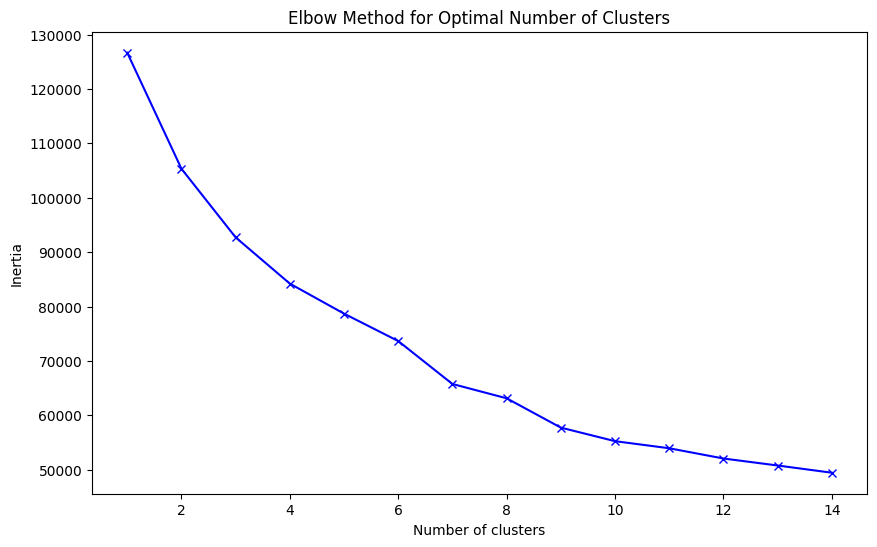

In [38]:
# determine the optimal number of clusters using the elbow method
inertia = []
K = range(1, 15)
# cast df back to numpy array 
X_final = X_final_df.to_numpy()
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=8)
    kmeans.fit(X_final)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [39]:
# Fit K-means with the optimal number of clusters
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
cluster_df['kmeans_cluster'] = kmeans.fit_predict(X_final)

# checking the clusters
print(cluster_df['kmeans_cluster'].value_counts().sort_index())
print(f'% of providers belonging to cluster:\n {cluster_df["kmeans_cluster"].value_counts().sort_index() / cluster_df.shape[0] * 100}')

kmeans_cluster
0    2472
1    1286
2     524
3    2972
4    1666
Name: count, dtype: int64
% of providers belonging to cluster:
 kmeans_cluster
0    27.713004
1    14.417040
2     5.874439
3    33.318386
4    18.677130
Name: count, dtype: float64


#### 8.1.1 Characterizing the identified clusters

In [40]:
# characterize the clusters based on the mean values of the features per cluster
cluster_df.groupby('kmeans_cluster').mean()

,Grouping_1_Agencies,Grouping_1_Allopathic & Osteopathic Physicians,Grouping_1_Ambulatory Health Care Facilities,Grouping_1_Behavioral Health & Social Service Providers,Grouping_1_Chiropractic Providers,Grouping_1_Dental Providers,Grouping_1_Dietary & Nutritional Service Providers,Grouping_1_Eye and Vision Services Providers,Grouping_1_Hospital Units,Grouping_1_Hospitals,Grouping_1_Laboratories,Grouping_1_Managed Care Organizations,Grouping_1_Nursing & Custodial Care Facilities,Grouping_1_Nursing Service Providers,Grouping_1_Nursing Service Related Providers,Grouping_1_Other Service Providers,Grouping_1_Pharmacy Service Providers,Grouping_1_Physician Assistants & Advanced Practice Nursing Providers,Grouping_1_Podiatric Medicine & Surgery Service Providers,Grouping_1_Residential Treatment Facilities,"Grouping_1_Respiratory, Developmental, Rehabilitative and Restorative Service Providers",Grouping_1_Respite Care Facility,"Grouping_1_Speech, Language and Hearing Service Providers","Grouping_1_Student, Health Care",Grouping_1_Suppliers,Grouping_1_Transportation Services,psychotherapy_provider_through_taxonomy_False,psychotherapy_provider_through_taxonomy_True,urbanity_Rural,urbanity_Urban,provider_size_Big,provider_size_Small,planning_accepts_new_patients_False,planning_accepts_new_patients_True,business_status_CLOSED,business_status_Info Not Available,business_status_OPERATIONAL,Weekend Availability_Info Not Available,Weekend Availability_No,Weekend Availability_Partially,Weekend Availability_Yes,Availability Before 8AM_Info Not Available,Availability Before 8AM_No,Availability Before 8AM_Yes,Availability After 5PM_Info Not Available,Availability After 5PM_No,Availability After 5PM_Yes,mental_health_False,mental_health_True,specialization_group_Community and Social Services,specialization_group_Emergency and Critical Care,specialization_group_Facility-Based Services,specialization_group_Internal Medicine and Specialties,specialization_group_Medical Imaging and Radiology,specialization_group_Multi-Specialty Groups and Organizations,specialization_group_Pediatrics,specialization_group_Primary Care and General,specialization_group_Primary Care and General Practice,specialization_group_Public Health and Preventive Medicine,specialization_group_Rehabilitation and Therapy,specialization_group_Specialized and Allied Health Services,specialization_group_Surgery and Related Specialties,specialization_group_Women Health,specialization_group_mental_health,working_hours_owner_missing_info_False,working_hours_owner_missing_info_True,minority_owned_False,minority_owned_True,total_claims,%psychotherapy_patients,%stdService_patients,%teleService_patients,%tele_psychotherapy_patients,transport_access,broadband_access,extra_languages_spoken,providers_per_county
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.015372,0.039239,0.009709,0.911812,0.000000,0.000000,0.000405,0.0000,0.000000,0.000809,0.000809,0.000405,0.000000,0.001214,0.000000,0.003236,0.0000,0.013754,0.0000,0.000405,0.001214,0.000000,0.000000,0.001214,0.000405,0.000000,0.080906,0.919094,0.109628,0.890372,0.013350,0.986650,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.447006,0.552994,0.028722,0.000000,0.002427,0.002832,0.000000,0.344256,0.015372,0.001214,0.046926,0.002023,0.002023,0.001214,0.000000,0.000000,0.552994,0.000000,1.000000,1.000000,0.000000,0.166374,0.927293,-0.485773,0.988891,0.864776,-0.041690,0.372968,-0.040051,0.029389
1,0.045101,0.111198,0.037325,0.761275,0.000000,0.000000,0.000778,0.0000,0.000000,0.000000,0.000000,0.000778,0.005443,0.000778,0.000000,0.006998,0.0000,0.022551,0.0000,0.000778,0.001555,0.000000,0.000000,0.004666,0.000000,0.000778,0.224728,0.775272,0.115086,0.884914,0.031104,0.968896,0.534215,0.465785,0.085537,0.000000,0.914463,0.000000,0.944790,0.036547,0.018663,0.000000,0.986003,0.013997,0.000000,0.832815,0.167185,0.4743

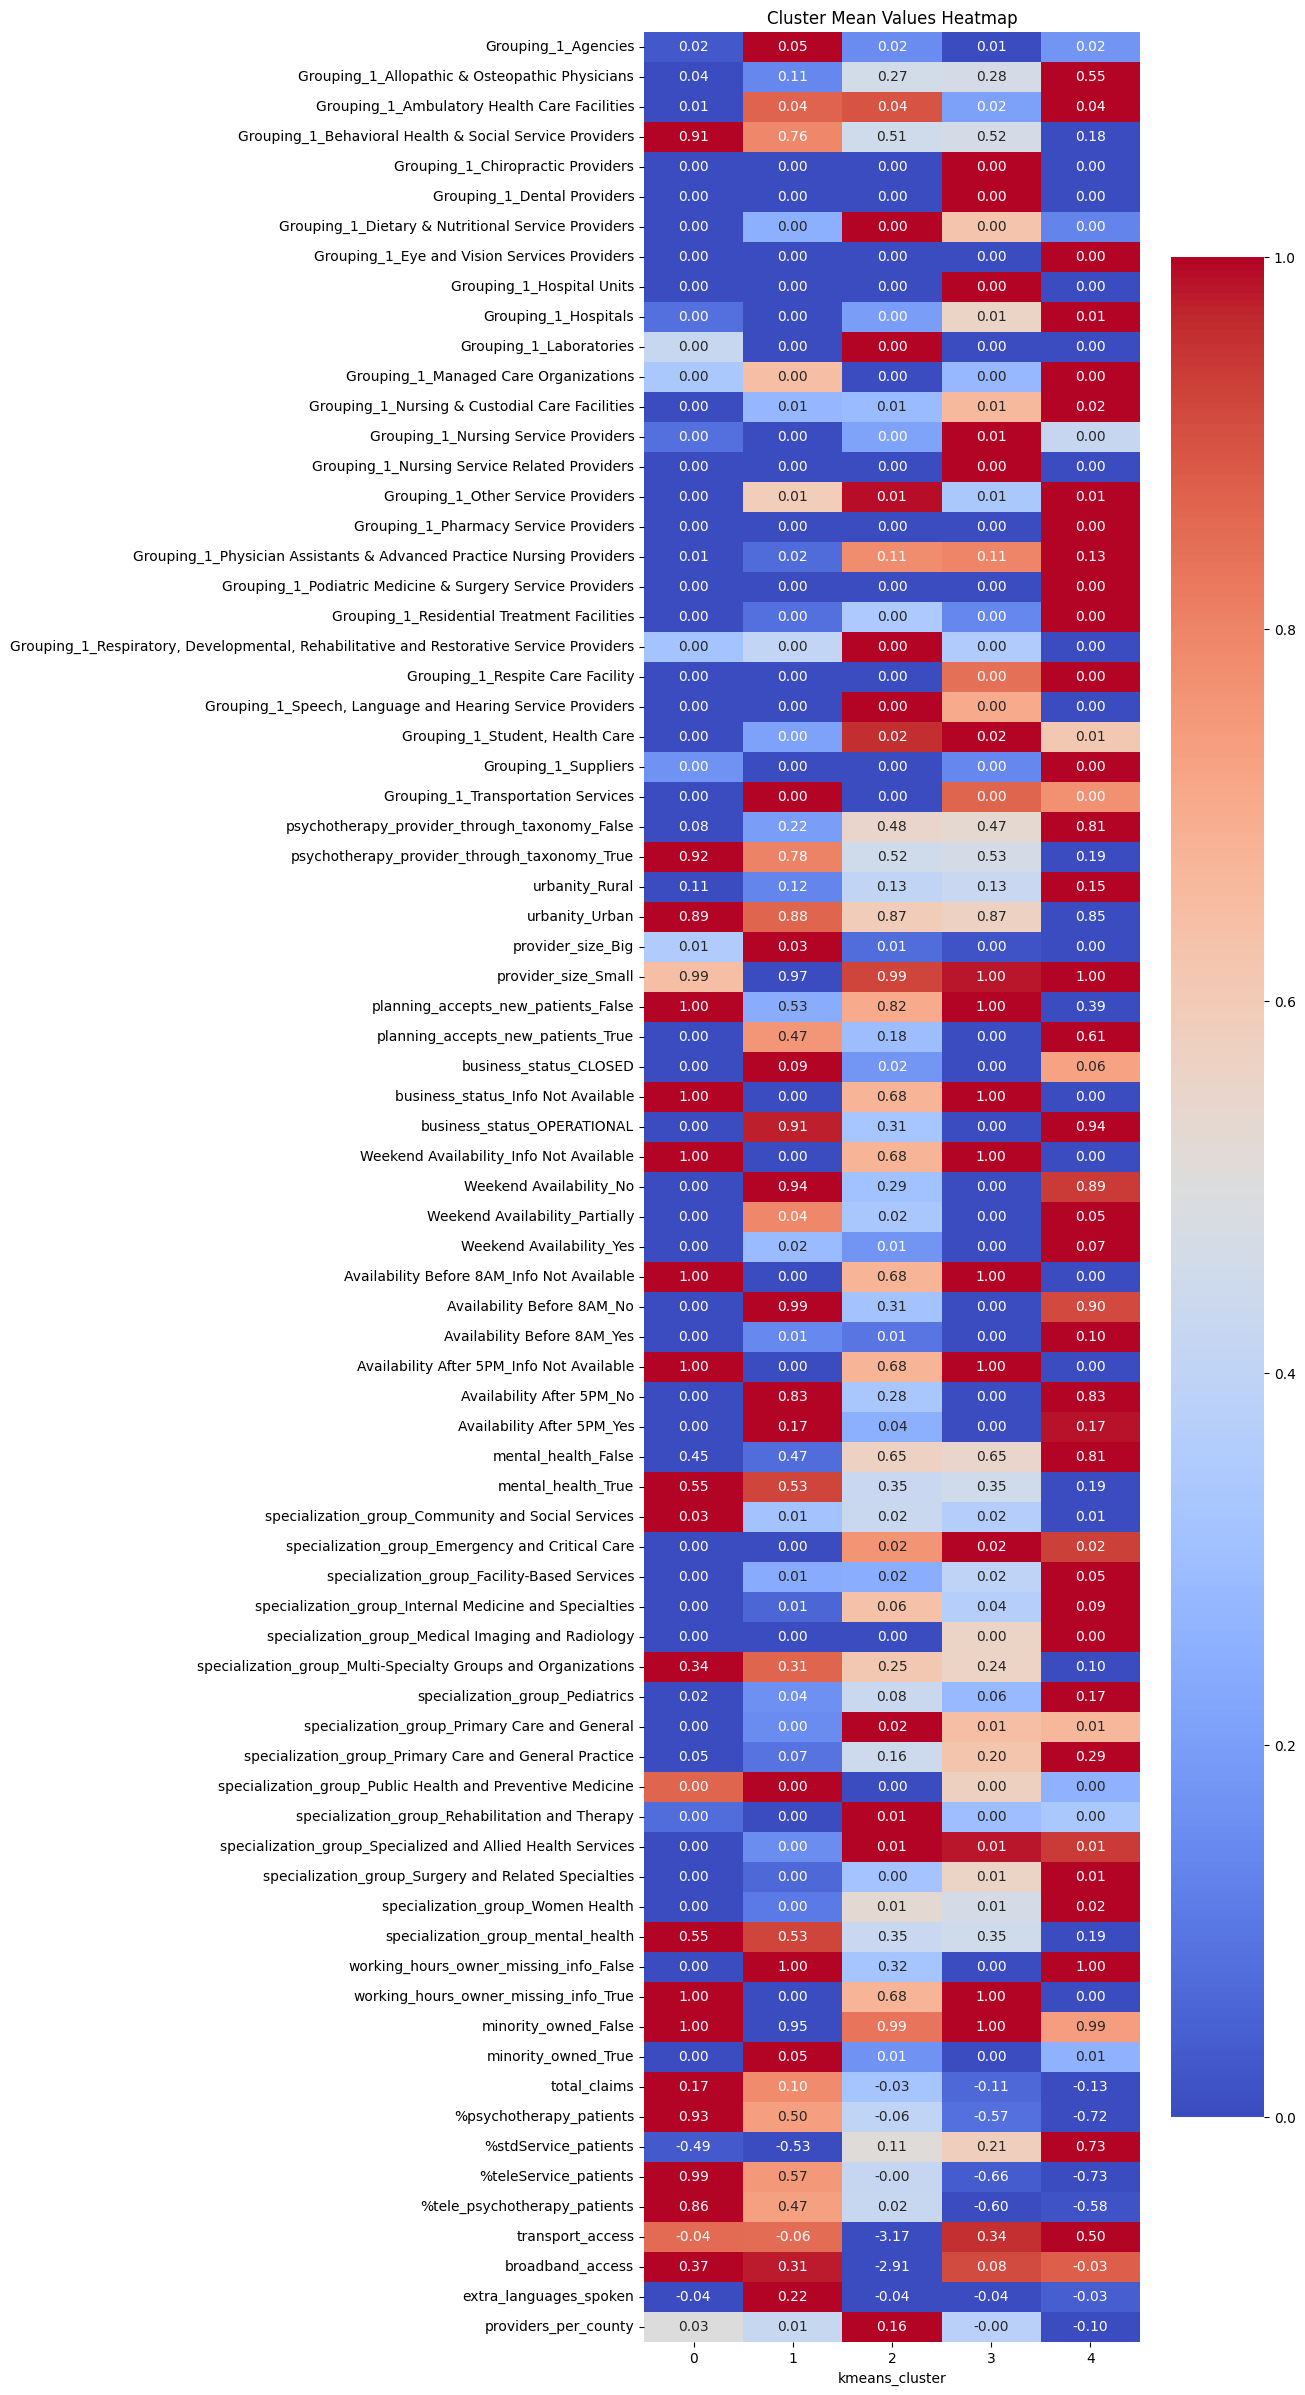

In [41]:
# plotting the above as a heatmap
grouped_means = cluster_df.groupby('kmeans_cluster').mean()

# each column is normalized independently to enable useful heatmap coloring
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(grouped_means)
normalized_df = pd.DataFrame(normalized_data, index=grouped_means.index, columns=grouped_means.columns)

# the heatmap is colored based on the normalized data per feature but it is the "original" mean values that are shown
plt.figure(figsize=(8, 30))
sns.heatmap(normalized_df.T, cmap='coolwarm', annot=grouped_means.T, fmt=".2f")  
plt.title('Cluster Mean Values Heatmap')
plt.show()

Creating a Random Forest classification model with the clusters as the target can yield insights regarding which features are most important for the clustering by evaluting the feature importances of the Random Forest. Additionally, if the clusters can be predicted with a high accuracy by the RF model, it suggests that the clusters are well defined and distinguishable from each other.

Random Forest Classifier Accuracy: 0.9811659192825112
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       643
           1       0.98      0.97      0.97       324
           2       1.00      0.99      1.00       115
           3       0.98      0.99      0.98       722
           4       0.98      0.98      0.98       426

    accuracy                           0.98      2230
   macro avg       0.98      0.98      0.98      2230
weighted avg       0.98      0.98      0.98      2230



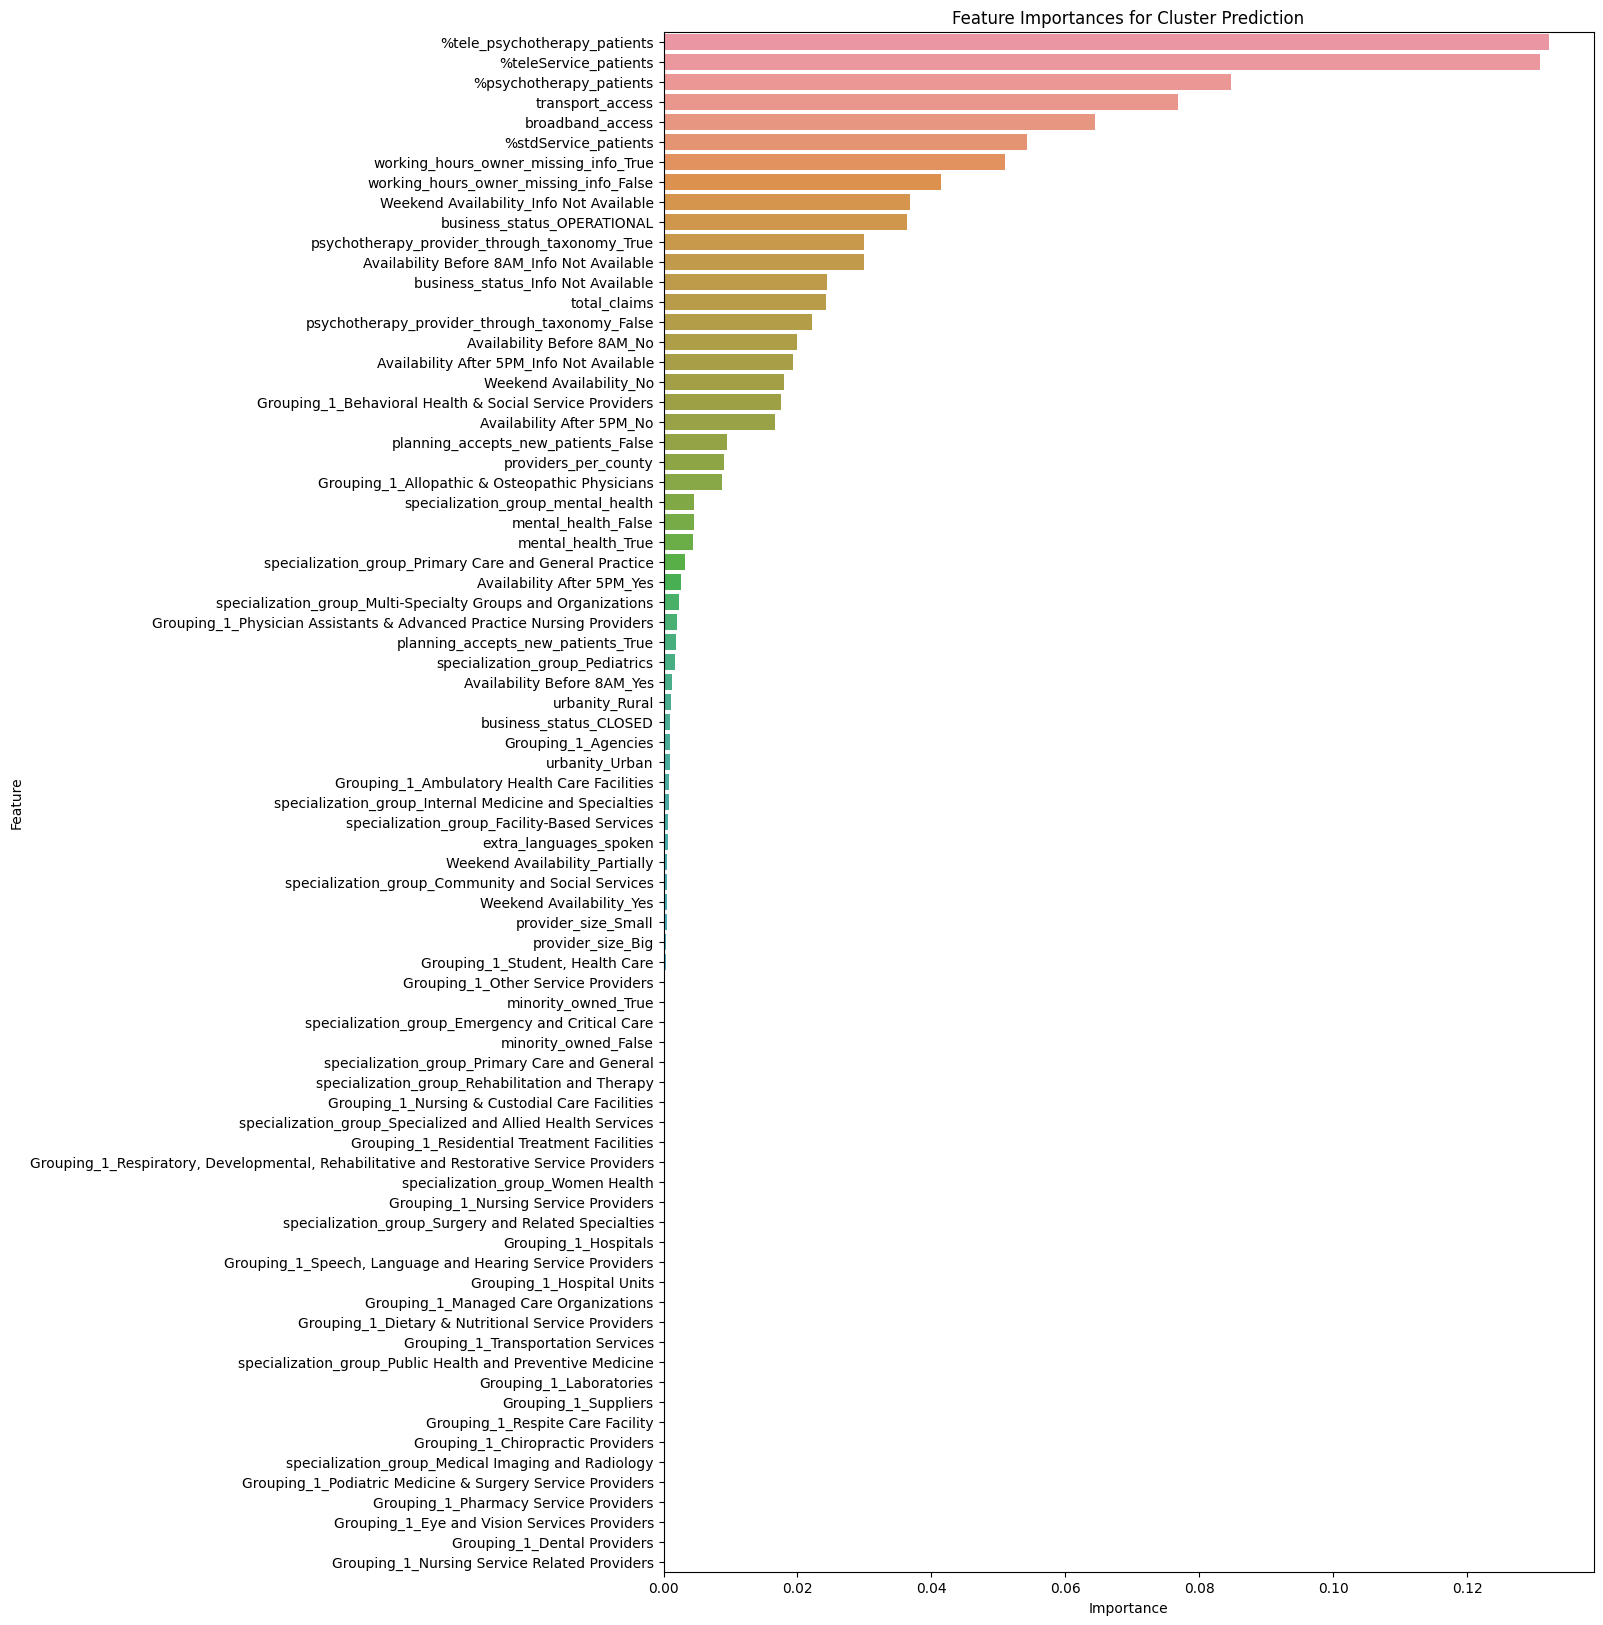

In [42]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final_df, cluster_df['kmeans_cluster'], test_size=0.25, random_state=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict the cluster labels for the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Classifier Accuracy: {accuracy}')

# Display classification report for detailed metrics
print(classification_report(y_test, y_pred))

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_final_df.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 20))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for Cluster Prediction')
plt.show()

#### 8.1.2 Evaluating the robustness of the clustering model

The robustness and reliability of the clustering is assessed using the Adjusted Rand Index (ARI). This involves splitting the dataset into two halves and fitting a K-Means model on subset. One of these K-Means models is then used to predict the cluster labels for the unseen data subset. The cluster labels produced by the two K-Means models are compared using the ARI. 

- ARI ranges from -1 to 1
    - 1: Perfect agreement between the two clusterings (i.e., the two clusterings are identical).
    - 0: The clustering results are no better than random assignments.
    - Negative values: Indicate that the agreement is worse than random assignments.

In [43]:
# to check the robustness of the clustering, we use adjusted_rand_score 

# Split the data into two halves
X1, X2 = train_test_split(X_final, test_size=0.5, random_state=8)

# Perform clustering on both halves
kmeans1 = KMeans(n_clusters=optimal_k, n_init=10, random_state=8).fit(X1)
kmeans2 = KMeans(n_clusters=optimal_k, n_init=10, random_state=8).fit(X2)

# Compare the clustering results
ari = adjusted_rand_score(kmeans1.labels_, kmeans2.predict(X1))

print(f'Adjusted Rand Index: {ari}')

Adjusted Rand Index: 0.9568066189972677


The high ARI value demonstrates that the clustering solution is consistent and reliable across different subsets of the data.

The NPIs and their respective clusters are saved:

In [44]:
# storing the NPIs and cluster classifications to enable mapping to the demand prediction
segmentation = cluster_df['kmeans_cluster'].reset_index()
mapping = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5} # mapping cluster values so they start from 1 instead of 0
segmentation['kmeans_cluster'] = segmentation['kmeans_cluster'].map(mapping) # executing mapping
segmentation.to_csv('segmentation.csv', index=False)

In [45]:
segmentation.head()

,npi,kmeans_cluster
0,1,1
1,2,3
2,3,5
3,4,4
4,5,4


In [46]:
cluster_df = cluster_df.drop(columns='kmeans_cluster')

### 9. Appendix <a id='9-appendix'></a>

#### 9.1 Agglomerative Clustering <a id='91-agglomerative'></a>

In [47]:
# creating a function to evaluate agglomerative clustering with different numbers of clusters using the silhouette score
def evaluate_aggl(X, n_clusters_list):
    best_n_clusters = None
    best_silhouette = -1
    silhouette_scores = []
    inertia_values = []
    
    for n_clusters in n_clusters_list:
        aggl = AgglomerativeClustering(n_clusters=n_clusters)
        labels = aggl.fit_predict(X)
        silhouette_avg = silhouette_score(X, labels)
        
        silhouette_scores.append(silhouette_avg)
        
        print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}')
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_n_clusters = n_clusters
    
    return best_n_clusters, best_silhouette

# Evaluate agglomerative clustering with different numbers of clusters
n_clusters_list = range(2, 15)
X_final = X_final_df.to_numpy()
best_n_clusters, best_silhouette = evaluate_aggl(X_final, n_clusters_list)

print(f'{best_n_clusters} number of clusters yields the highest silhouette score: {best_silhouette}')

Number of clusters: 2, Silhouette Score: 0.20482157363081913
Number of clusters: 3, Silhouette Score: 0.2310837817178127
Number of clusters: 4, Silhouette Score: 0.1463461121713482
Number of clusters: 5, Silhouette Score: 0.15309318694740928
Number of clusters: 6, Silhouette Score: 0.15228916143952823
Number of clusters: 7, Silhouette Score: 0.15441898582249838
Number of clusters: 8, Silhouette Score: 0.15267298275106764
Number of clusters: 9, Silhouette Score: 0.15423499378177266
Number of clusters: 10, Silhouette Score: 0.1438700870425907
Number of clusters: 11, Silhouette Score: 0.1494282596786687
Number of clusters: 12, Silhouette Score: 0.15262785852271335
Number of clusters: 13, Silhouette Score: 0.1386741064077666
Number of clusters: 14, Silhouette Score: 0.14294817642769359
3 number of clusters yields the highest silhouette score: 0.2310837817178127


In [48]:
# Fit Agglomerative Clustering (hierarchical clustering) with the optimal number of clusters
agg = AgglomerativeClustering(n_clusters=optimal_k) # bottom-up approach
cluster_df['agg_cluster'] = agg.fit_predict(X_final)

# checking the clusters
cluster_df['agg_cluster'].value_counts().sort_index()

agg_cluster
0    3006
1    3761
2     521
3    1616
4      16
Name: count, dtype: int64

#### 9.1.1 Characterizing the identified clusters

In [49]:
cluster_df.groupby('agg_cluster').mean()

,Grouping_1_Agencies,Grouping_1_Allopathic & Osteopathic Physicians,Grouping_1_Ambulatory Health Care Facilities,Grouping_1_Behavioral Health & Social Service Providers,Grouping_1_Chiropractic Providers,Grouping_1_Dental Providers,Grouping_1_Dietary & Nutritional Service Providers,Grouping_1_Eye and Vision Services Providers,Grouping_1_Hospital Units,Grouping_1_Hospitals,Grouping_1_Laboratories,Grouping_1_Managed Care Organizations,Grouping_1_Nursing & Custodial Care Facilities,Grouping_1_Nursing Service Providers,Grouping_1_Nursing Service Related Providers,Grouping_1_Other Service Providers,Grouping_1_Pharmacy Service Providers,Grouping_1_Physician Assistants & Advanced Practice Nursing Providers,Grouping_1_Podiatric Medicine & Surgery Service Providers,Grouping_1_Residential Treatment Facilities,"Grouping_1_Respiratory, Developmental, Rehabilitative and Restorative Service Providers",Grouping_1_Respite Care Facility,"Grouping_1_Speech, Language and Hearing Service Providers","Grouping_1_Student, Health Care",Grouping_1_Suppliers,Grouping_1_Transportation Services,psychotherapy_provider_through_taxonomy_False,psychotherapy_provider_through_taxonomy_True,urbanity_Rural,urbanity_Urban,provider_size_Big,provider_size_Small,planning_accepts_new_patients_False,planning_accepts_new_patients_True,business_status_CLOSED,business_status_Info Not Available,business_status_OPERATIONAL,Weekend Availability_Info Not Available,Weekend Availability_No,Weekend Availability_Partially,Weekend Availability_Yes,Availability Before 8AM_Info Not Available,Availability Before 8AM_No,Availability Before 8AM_Yes,Availability After 5PM_Info Not Available,Availability After 5PM_No,Availability After 5PM_Yes,mental_health_False,mental_health_True,specialization_group_Community and Social Services,specialization_group_Emergency and Critical Care,specialization_group_Facility-Based Services,specialization_group_Internal Medicine and Specialties,specialization_group_Medical Imaging and Radiology,specialization_group_Multi-Specialty Groups and Organizations,specialization_group_Pediatrics,specialization_group_Primary Care and General,specialization_group_Primary Care and General Practice,specialization_group_Public Health and Preventive Medicine,specialization_group_Rehabilitation and Therapy,specialization_group_Specialized and Allied Health Services,specialization_group_Surgery and Related Specialties,specialization_group_Women Health,specialization_group_mental_health,working_hours_owner_missing_info_False,working_hours_owner_missing_info_True,minority_owned_False,minority_owned_True,total_claims,%psychotherapy_patients,%stdService_patients,%teleService_patients,%tele_psychotherapy_patients,transport_access,broadband_access,extra_languages_spoken,providers_per_county
agg_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.030273,0.358616,0.039587,0.435795,0.000000,0.000000,0.000665,0.000333,0.000000,0.007319,0.000665,0.000998,0.013972,0.001996,0.000000,0.008982,0.000333,0.085163,0.000333,0.002661,0.000665,0.000665,0.000665,0.008317,0.001331,0.000665,0.554558,0.445442,0.133067,0.866933,0.029275,0.970725,0.466068,0.533932,0.071191,0.023952,0.904857,0.023952,0.891883,0.040918,0.043247,0.023952,0.916168,0.059880,0.023952,0.816035,0.160013,0.657352,0.342648,0.010645,0.011643,0.039255,0.055888,0.000665,0.192282,0.111111,0.008982,0.193945,0.001331,0.003327,0.008317,0.006986,0.012974,0.342648,0.976048,0.023952,0.975383,0.024617,0.101241,-0.186341,0.176917,-0.142780,-0.100326,0.255037,0.123254,-0.040051,-0.049649
1,0.019144,0.240893,0.018346,0.580431,0.000532,0.000266,0.001329,0.000000,0.001064,0.003191,0.000266,0.000532,0.009838,0.005584,0.000266,0.005850,0.000000,0.093592,0.000000,0.000798,0.001329,0.000798,0.000532,0.014358,0.000532,0.000532,0.413454,0.586546,0.118851,0.881149,0.000798,0.999202,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.00

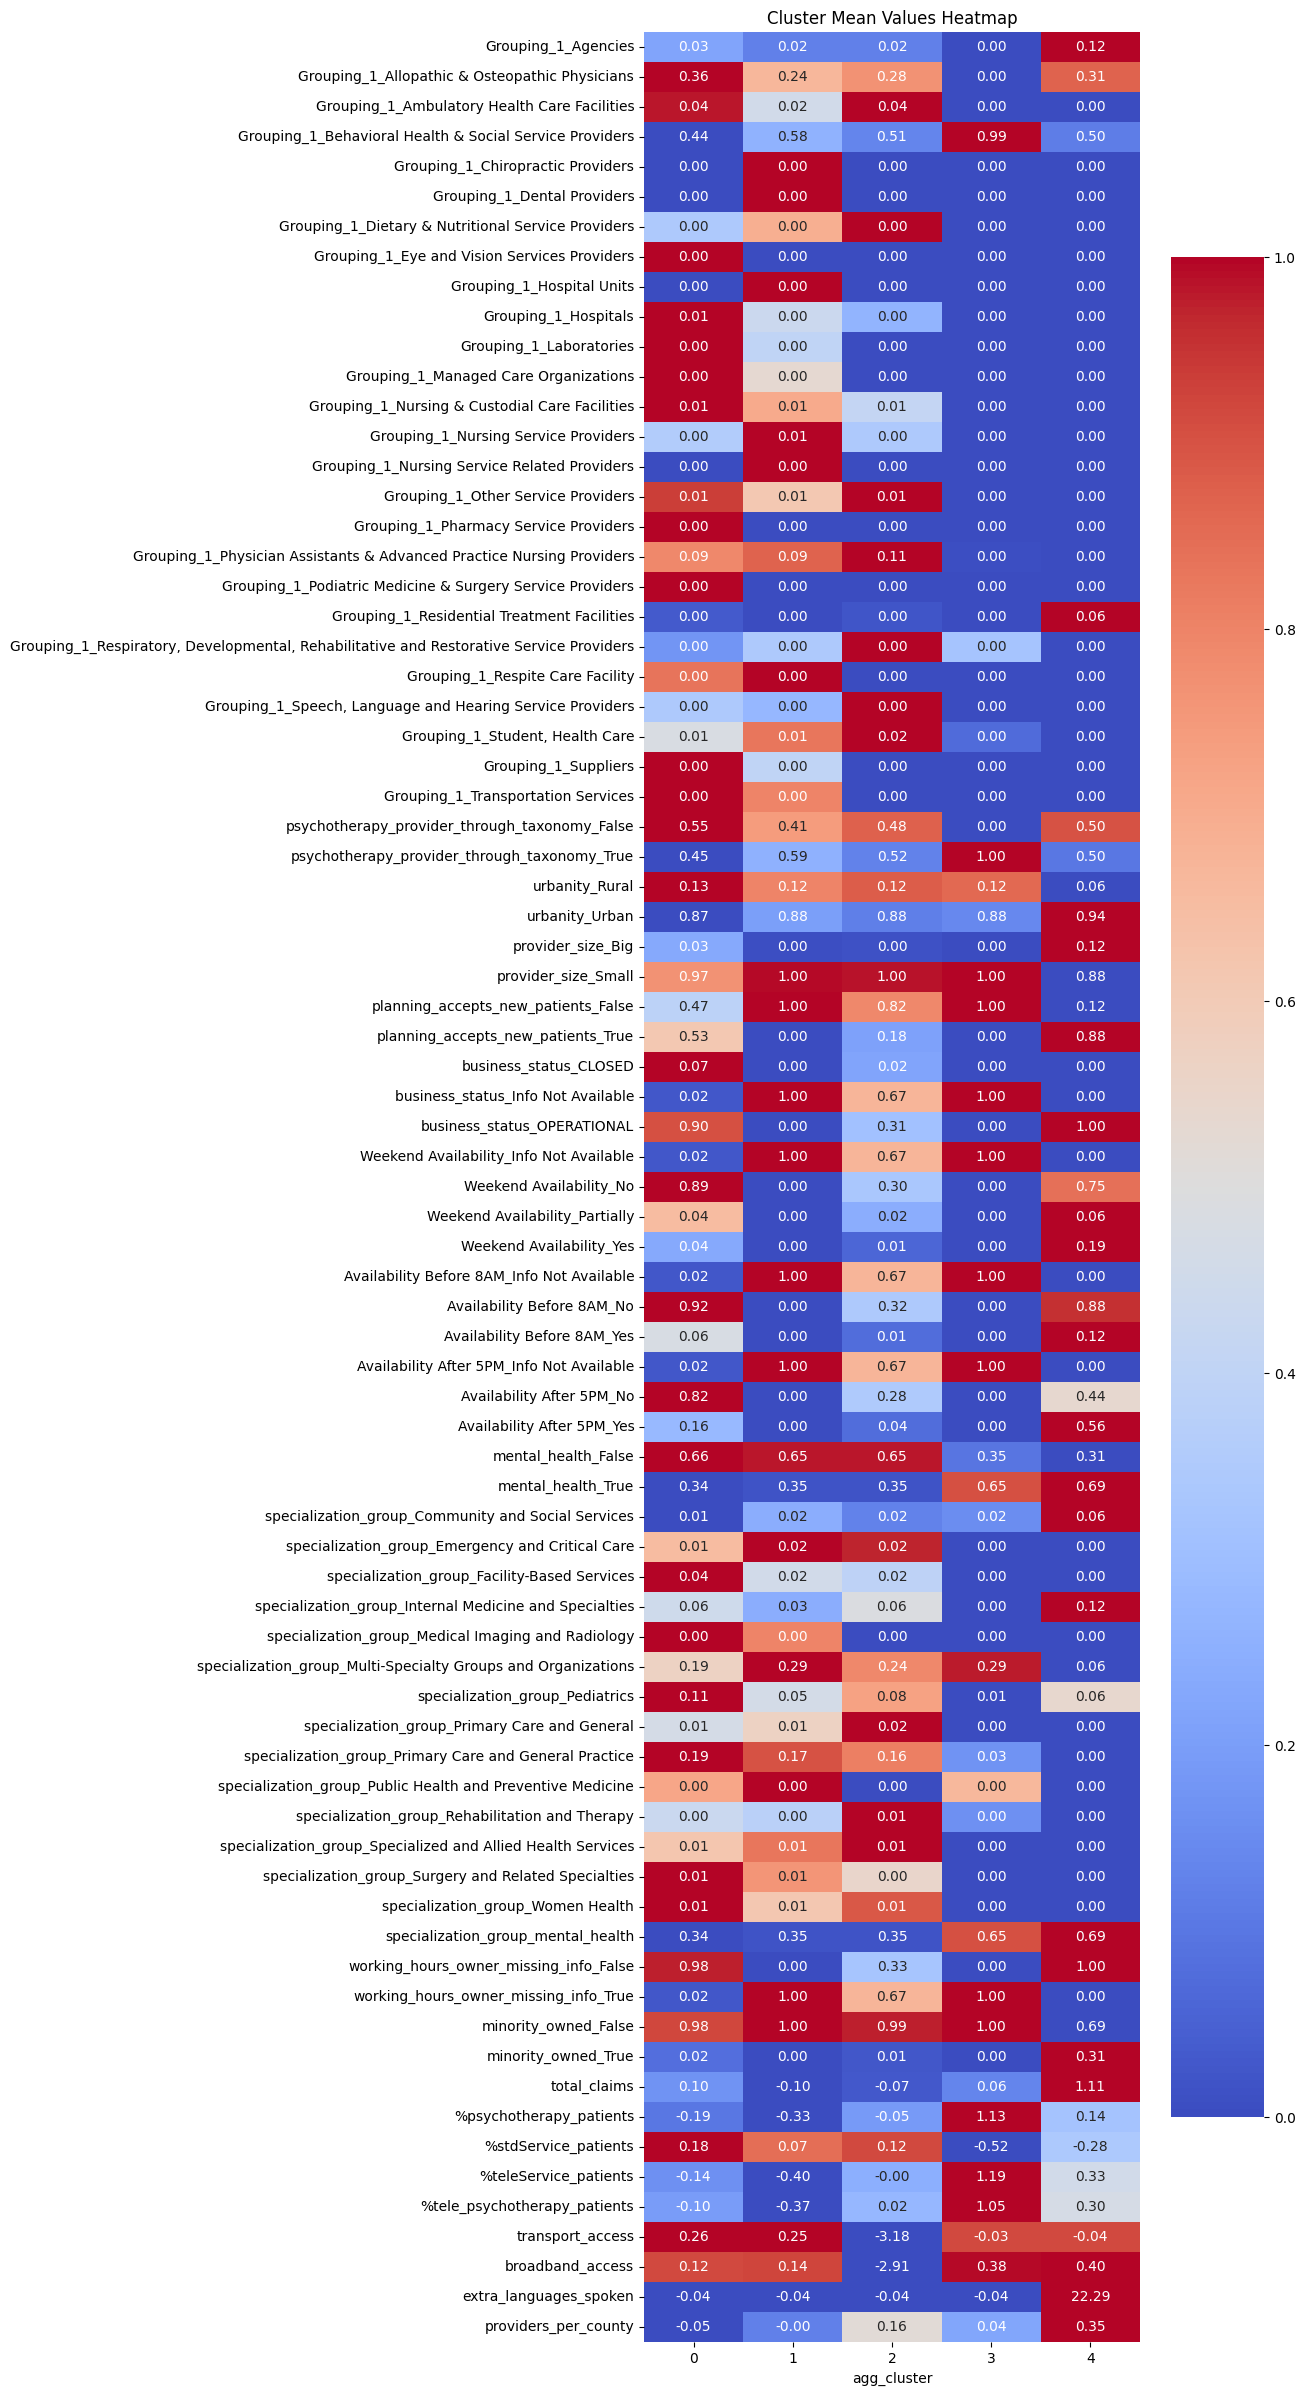

In [50]:
# plotting the above as a heatmap
grouped_means_aggl = cluster_df.groupby('agg_cluster').mean()

# each column is normalized independently to enable useful heatmap coloring
scaler = MinMaxScaler()
normalized_data_aggl = scaler.fit_transform(grouped_means_aggl)
normalized_df_aggl = pd.DataFrame(normalized_data_aggl, index=grouped_means_aggl.index, columns=grouped_means_aggl.columns)

# the heatmap is colored based on the normalized data but it is the "original" mean values that are shown
plt.figure(figsize=(8, 30))
sns.heatmap(normalized_df_aggl.T, cmap='coolwarm', annot=grouped_means_aggl.T, fmt=".2f")  # Use .T to transpose the DataFrame
plt.title('Cluster Mean Values Heatmap')
plt.show()

Random Forest Classifier Accuracy: 0.9825112107623318
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       766
           1       0.98      0.99      0.98       931
           2       1.00      0.99      1.00       115
           3       0.98      0.96      0.97       413
           4       0.00      0.00      0.00         5

    accuracy                           0.98      2230
   macro avg       0.79      0.79      0.79      2230
weighted avg       0.98      0.98      0.98      2230



/Users/philipdias/anaconda3/envs/pda_ie_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/philipdias/anaconda3/envs/pda_ie_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/philipdias/anaconda3/envs/pda_ie_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

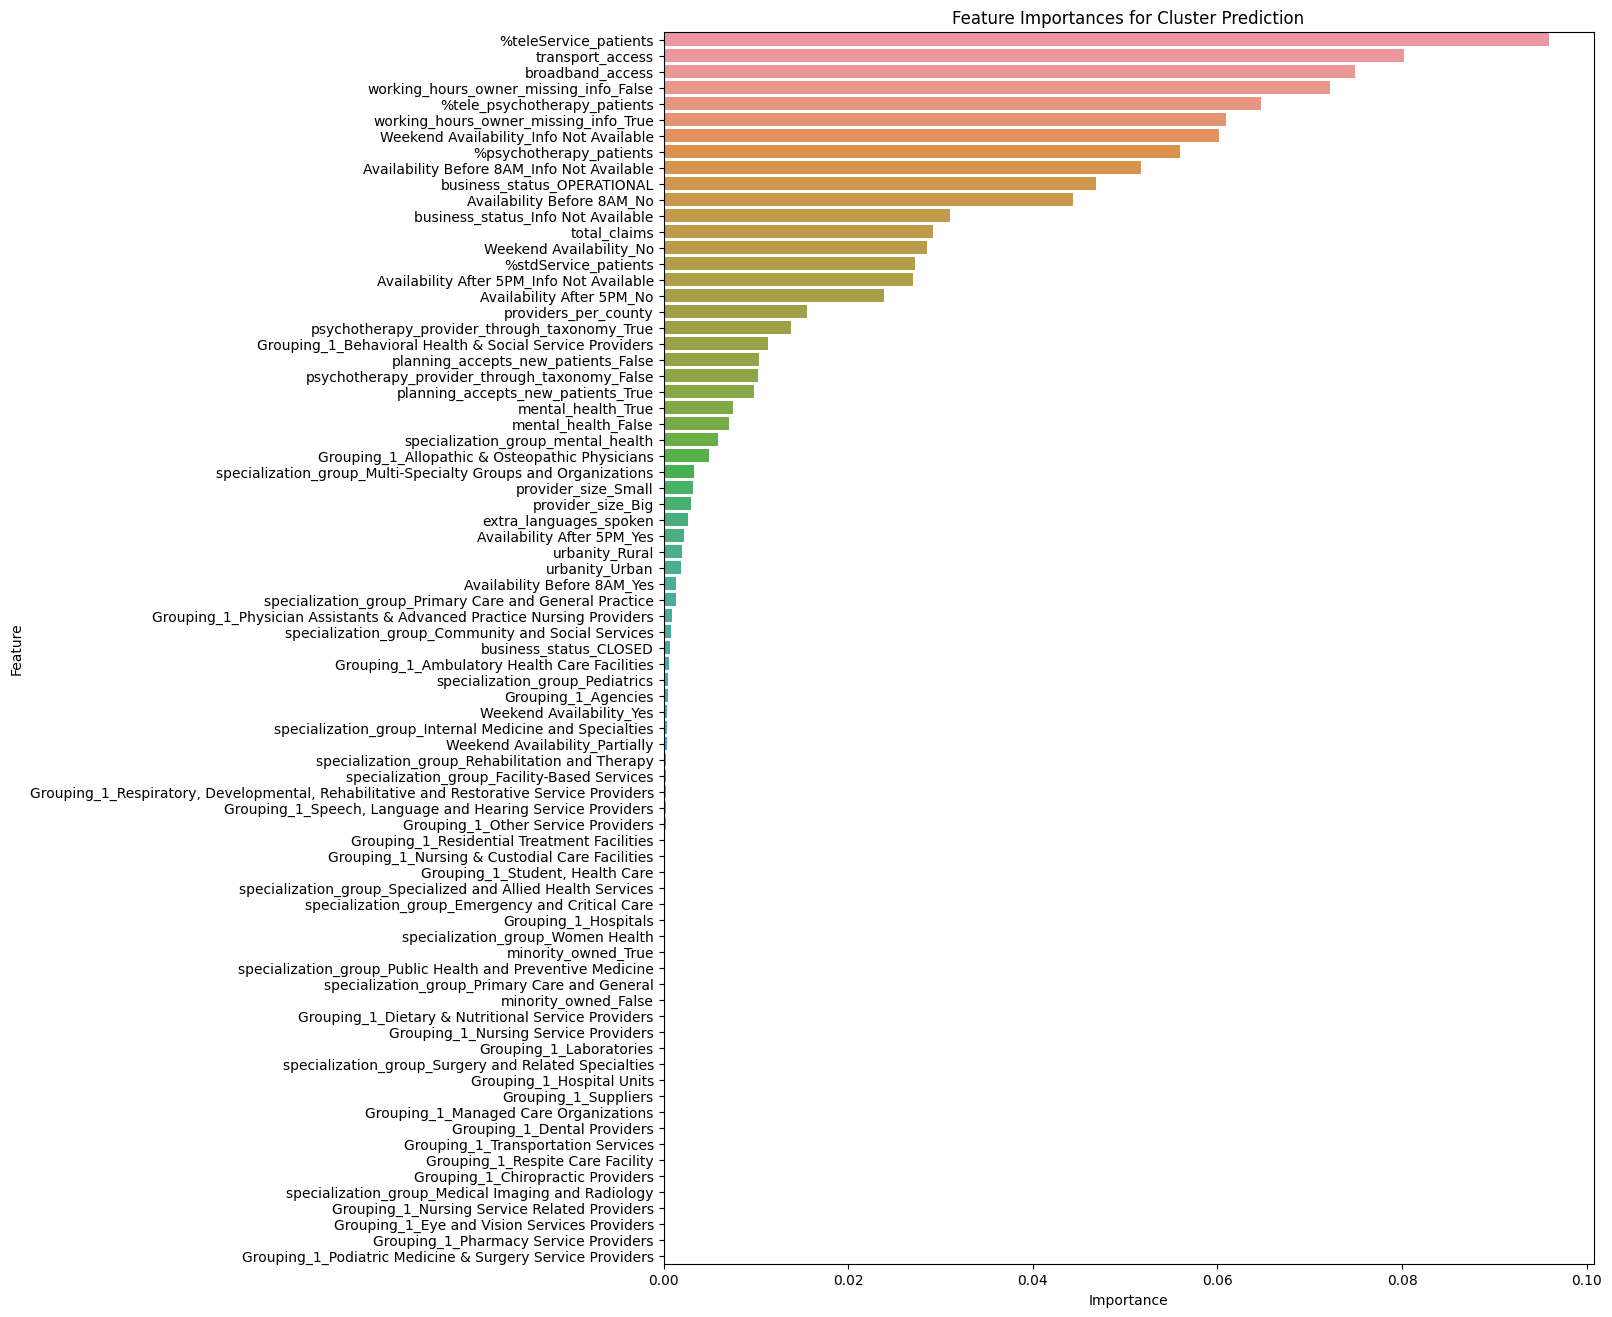

In [51]:
# creating a Random Forest classification model with the clusters as the target can yield insights regarding which features are most important for the clustering
# additionally, if the clusters can be predicted with a high accuracy by the RF model, it suggests that the clusters are well defined and distinguishable from each other

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final_df, cluster_df['agg_cluster'], test_size=0.25, random_state=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict the cluster labels for the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Classifier Accuracy: {accuracy}')

# Display classification report for detailed metrics
print(classification_report(y_test, y_pred))

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_final_df.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 16))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for Cluster Prediction')
plt.show()

#### 9.1.2 Inspecting the dendogram

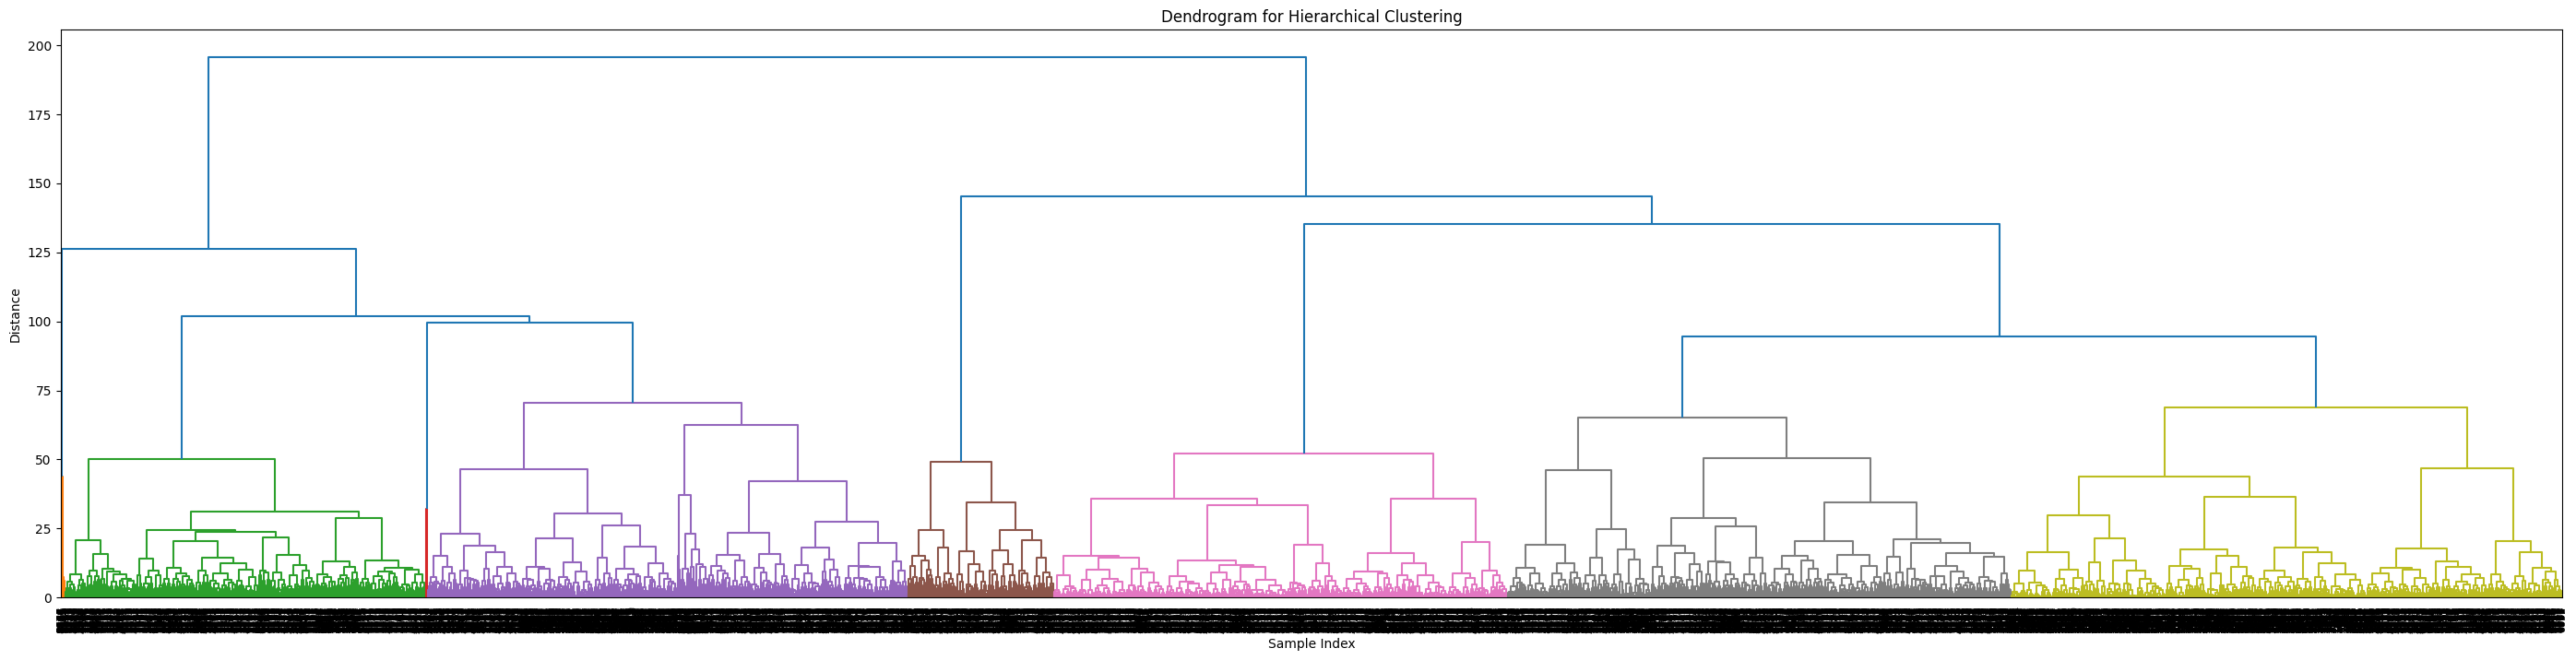

In [52]:
# visualizing the AgglomerativeClustering (hierarchical clustering) using a Dendogram

# Plot the dendrogram
# Compute the linkage matrix using the 'ward' method
Z = linkage(X_final, method='ward')

plt.figure(figsize=(35, 8))
dendrogram(Z, leaf_rotation=90., leaf_font_size=8., color_threshold=75)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

#### 9.1.3 Evaluating the robustness of the clustering model

In [53]:
# Split the data into two halves
X1, X2 = train_test_split(X_final, test_size=0.5, random_state=8)

# Perform clustering on both halves
agg1 = AgglomerativeClustering(n_clusters=optimal_k).fit(X1)
agg2 = AgglomerativeClustering(n_clusters=optimal_k).fit(X2)

# Predict the labels on both halves
labels1 = agg1.labels_
labels2 = agg2.labels_

# Create a combined dataset for comparison
X_combined = np.concatenate((X1, X2), axis=0)
labels_combined = np.concatenate((labels1, labels2), axis=0)

# Perform clustering on the combined dataset
agg_combined = AgglomerativeClustering(n_clusters=optimal_k).fit(X_combined)
labels_combined_pred = agg_combined.labels_

# Compare the clustering results using Adjusted Rand Index
ari = adjusted_rand_score(labels_combined, labels_combined_pred)
print(f'Adjusted Rand Index: {ari}')

Adjusted Rand Index: 0.1939878015380575


In [54]:
cluster_df.drop(columns=['agg_cluster'], inplace=True)

#### 9.2 DBSCAN <a id='92-dbscan'></a>

In [55]:
# Fit DBSCAN
X_final = X_final_df.to_numpy()
dbscan = DBSCAN(eps=3.1, min_samples=500)  # parameters
cluster_df['dbscan_cluster'] = dbscan.fit_predict(X_final)

# Check the clusters
print(cluster_df['dbscan_cluster'].value_counts())

dbscan_cluster
 0    5506
 1    2751
-1     663
Name: count, dtype: int64


Many different values for Epsilon and minimum samples have been experimented with. However, for our dataset, DBSCAN either puts most observations in the "noise" cluster or creates very few clusters with little practical relevance.

#### 9.2.1 Characterizing the identified clusters

In [56]:
cluster_df.groupby('dbscan_cluster').mean()

,Grouping_1_Agencies,Grouping_1_Allopathic & Osteopathic Physicians,Grouping_1_Ambulatory Health Care Facilities,Grouping_1_Behavioral Health & Social Service Providers,Grouping_1_Chiropractic Providers,Grouping_1_Dental Providers,Grouping_1_Dietary & Nutritional Service Providers,Grouping_1_Eye and Vision Services Providers,Grouping_1_Hospital Units,Grouping_1_Hospitals,Grouping_1_Laboratories,Grouping_1_Managed Care Organizations,Grouping_1_Nursing & Custodial Care Facilities,Grouping_1_Nursing Service Providers,Grouping_1_Nursing Service Related Providers,Grouping_1_Other Service Providers,Grouping_1_Pharmacy Service Providers,Grouping_1_Physician Assistants & Advanced Practice Nursing Providers,Grouping_1_Podiatric Medicine & Surgery Service Providers,Grouping_1_Residential Treatment Facilities,"Grouping_1_Respiratory, Developmental, Rehabilitative and Restorative Service Providers",Grouping_1_Respite Care Facility,"Grouping_1_Speech, Language and Hearing Service Providers","Grouping_1_Student, Health Care",Grouping_1_Suppliers,Grouping_1_Transportation Services,psychotherapy_provider_through_taxonomy_False,psychotherapy_provider_through_taxonomy_True,urbanity_Rural,urbanity_Urban,provider_size_Big,provider_size_Small,planning_accepts_new_patients_False,planning_accepts_new_patients_True,business_status_CLOSED,business_status_Info Not Available,business_status_OPERATIONAL,Weekend Availability_Info Not Available,Weekend Availability_No,Weekend Availability_Partially,Weekend Availability_Yes,Availability Before 8AM_Info Not Available,Availability Before 8AM_No,Availability Before 8AM_Yes,Availability After 5PM_Info Not Available,Availability After 5PM_No,Availability After 5PM_Yes,mental_health_False,mental_health_True,specialization_group_Community and Social Services,specialization_group_Emergency and Critical Care,specialization_group_Facility-Based Services,specialization_group_Internal Medicine and Specialties,specialization_group_Medical Imaging and Radiology,specialization_group_Multi-Specialty Groups and Organizations,specialization_group_Pediatrics,specialization_group_Primary Care and General,specialization_group_Primary Care and General Practice,specialization_group_Public Health and Preventive Medicine,specialization_group_Rehabilitation and Therapy,specialization_group_Specialized and Allied Health Services,specialization_group_Surgery and Related Specialties,specialization_group_Women Health,specialization_group_mental_health,working_hours_owner_missing_info_False,working_hours_owner_missing_info_True,minority_owned_False,minority_owned_True,total_claims,%psychotherapy_patients,%stdService_patients,%teleService_patients,%tele_psychotherapy_patients,transport_access,broadband_access,extra_languages_spoken,providers_per_county
dbscan_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,0.045249,0.273002,0.081448,0.377074,0.000000,0.000000,0.001508,0.000000,0.000000,0.024133,0.003017,0.000000,0.042232,0.003017,0.000000,0.013575,0.000000,0.098039,0.000000,0.009050,0.003017,0.003017,0.003017,0.016591,0.001508,0.001508,0.610860,0.389140,0.159879,0.840121,0.107089,0.892911,0.726998,0.273002,0.037707,0.443439,0.518854,0.443439,0.383107,0.057315,0.116139,0.443439,0.438914,0.117647,0.443439,0.312217,0.244344,0.625943,0.374057,0.019608,0.015083,0.090498,0.054299,0.000000,0.174962,0.073906,0.015083,0.144796,0.000000,0.012066,0.012066,0.004525,0.009050,0.374057,0.556561,0.443439,0.953243,0.046757,0.799169,-0.109539,0.223516,0.029354,0.055305,-2.024824,-1.891030,0.498799,0.229818
0,0.014893,0.166909,0.012532,0.705957,0.000363,0.000182,0.000908,0.000000,0.000726,0.002906,0.000182,0.000363,0.007083,0.003814,0.000182,0.004177,0.000000,0.064838,0.000000,0.000726,0.001271,0.000545,0.000545,0.010171,0.000363,0.000363,0.287686,0.712314,0.118961,0.881039,0.003451,0.996549,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.

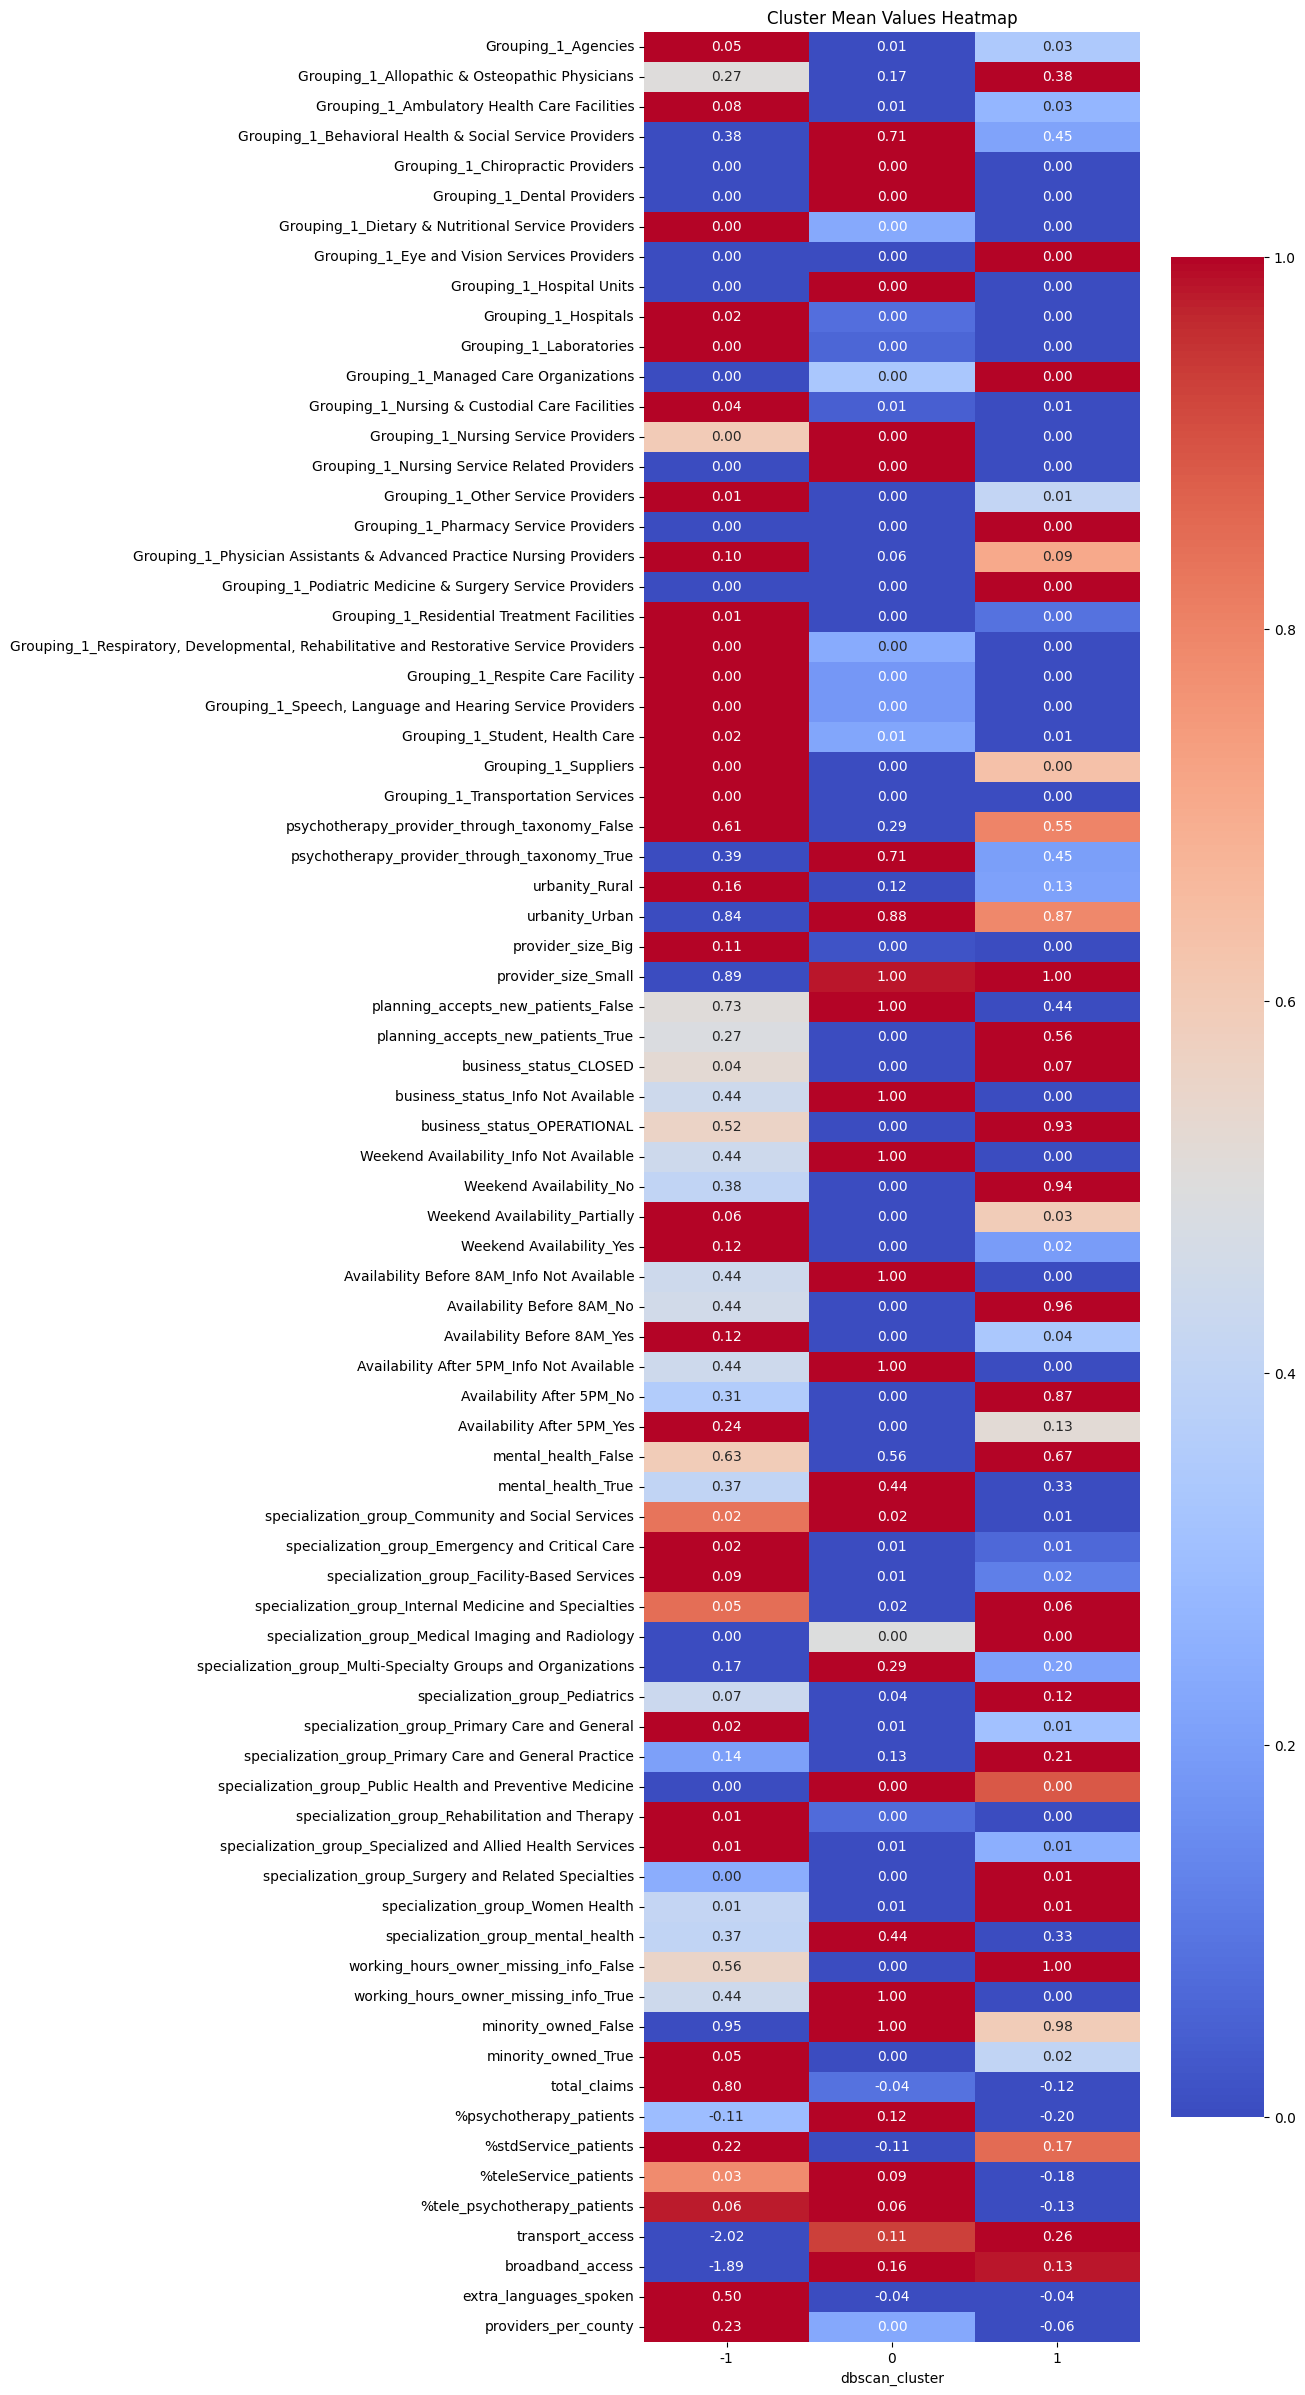

In [57]:
# plotting the above as a heatmap
grouped_means_db = cluster_df.groupby('dbscan_cluster').mean()

# each column is normalized independently to enable useful heatmap coloring
scaler = MinMaxScaler()
normalized_data_db = scaler.fit_transform(grouped_means_db)
normalized_df_db = pd.DataFrame(normalized_data_db, index=grouped_means_db.index, columns=grouped_means_db.columns)

# the heatmap is colored based on the normalized data but it is the "original" mean values that are shown
plt.figure(figsize=(8, 30))
sns.heatmap(normalized_df_db.T, cmap='coolwarm', annot=grouped_means_db.T, fmt=".2f")  # Use .T to transpose the DataFrame
plt.title('Cluster Mean Values Heatmap')
plt.show()

Random Forest Classifier Accuracy: 0.9834080717488789
              precision    recall  f1-score   support

          -1       0.95      0.80      0.87       151
           0       1.00      1.00      1.00      1379
           1       0.96      1.00      0.98       700

    accuracy                           0.98      2230
   macro avg       0.97      0.93      0.95      2230
weighted avg       0.98      0.98      0.98      2230



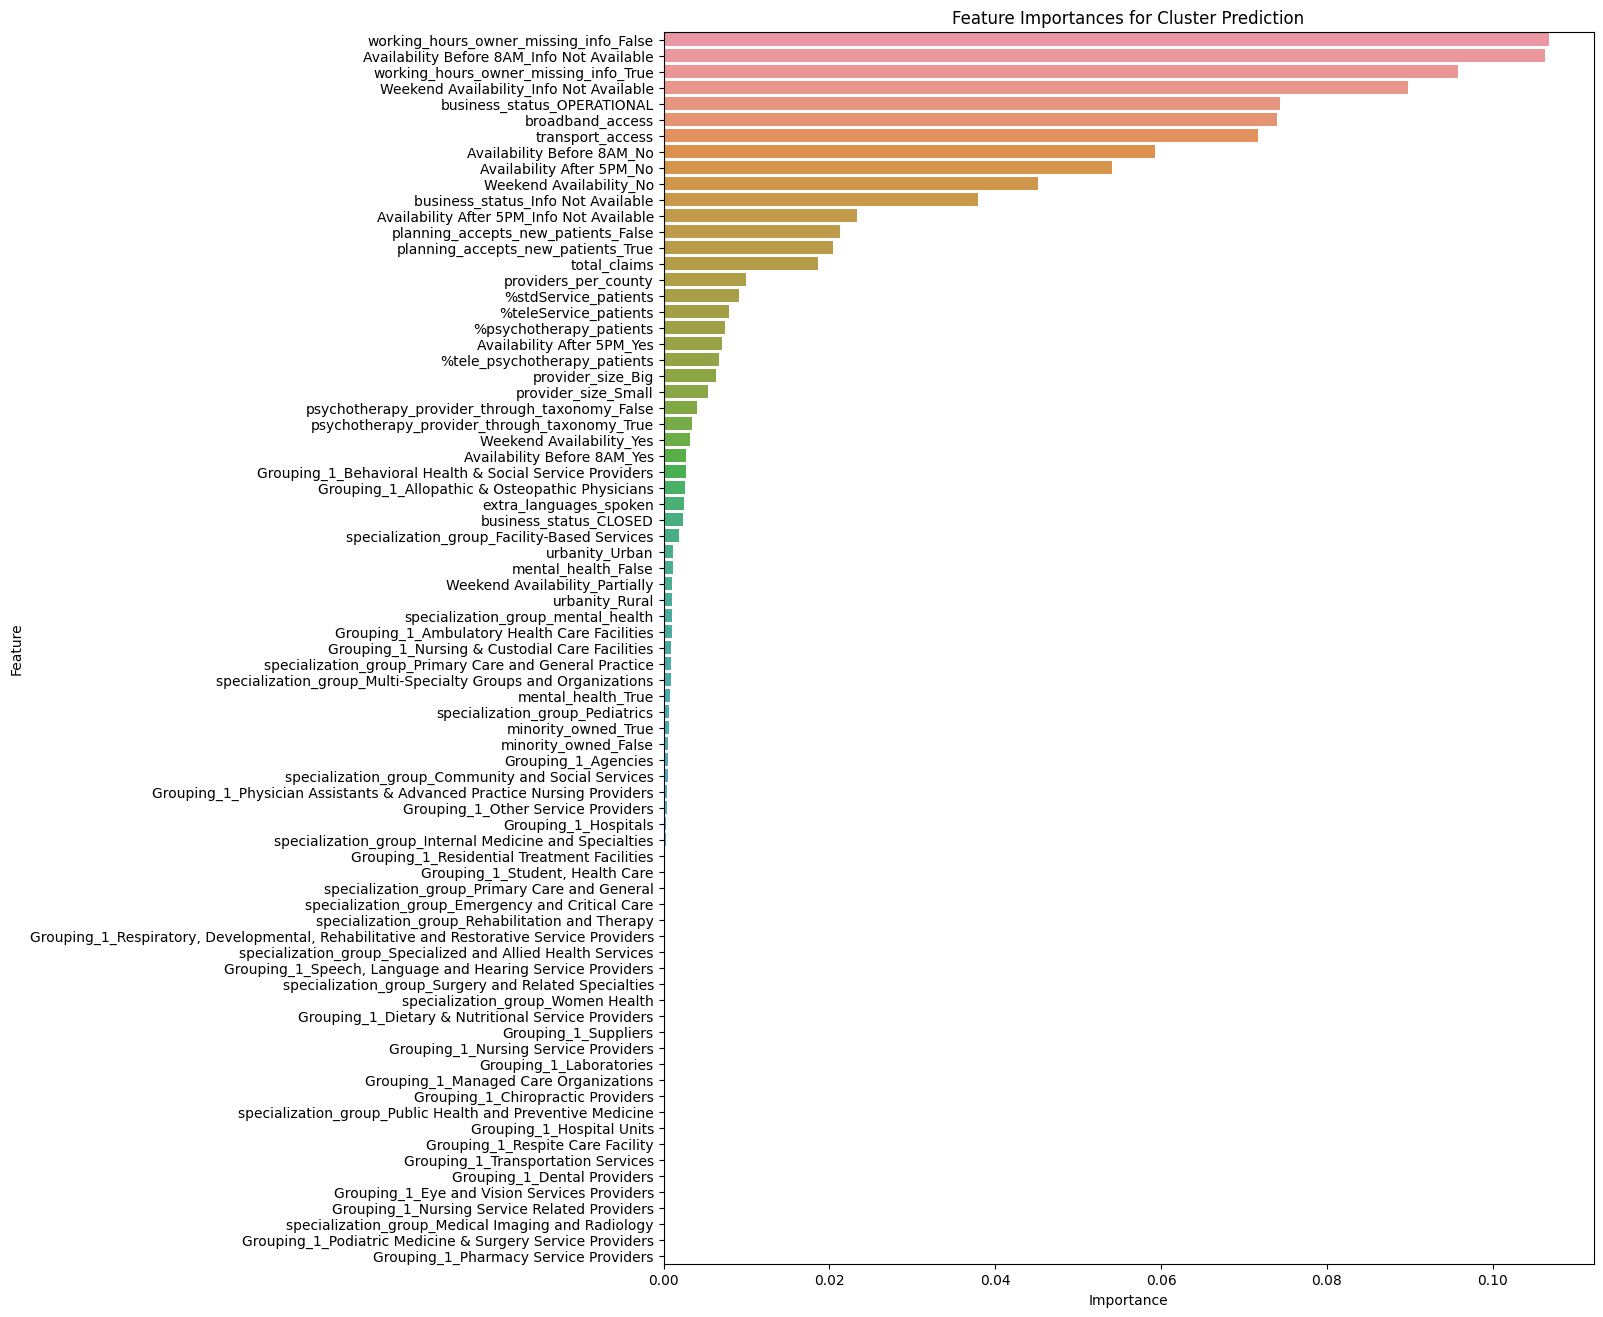

In [58]:
# creating a Random Forest classification model with the clusters as the target can yield insights regarding which features are most important for the clustering
# additionally, if the clusters can be predicted with a high accuracy by the RF model, it suggests that the clusters are well defined and distinguishable from each other

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final_df, cluster_df['dbscan_cluster'], test_size=0.25, random_state=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict the cluster labels for the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Classifier Accuracy: {accuracy}')

# Display classification report for detailed metrics
print(classification_report(y_test, y_pred))

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': cluster_df.drop(columns='dbscan_cluster').columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 16))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for Cluster Prediction')
plt.show()

In [59]:
cluster_df.drop(columns=['dbscan_cluster'], inplace=True)